In [4]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error,max_error,mean_squared_error
from matplotlib import pyplot as plt
from datetime import datetime
from sklearn.model_selection import GridSearchCV
import numpy as np
from autorank import autorank, plot_stats, create_report, latex_table
from mpl_toolkits.mplot3d import Axes3D

## Date pre-process

In [5]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [6]:

from statsmodels.tsa.stattools import adfuller

In [7]:
df = pd.read_csv('Turbine_Data.csv')
df.rename(columns={'Unnamed: 0': 'Datetime'}, inplace=True)
df['Datetime']=df.Datetime.map(lambda x: x[:19])
df['Datetime']=pd.to_datetime(df['Datetime'],format='%Y-%m-%d %H:%M:%S')
df.drop(columns=['Blade3PitchAngle','Blade2PitchAngle'],inplace=True)

#process na value
df.drop(df[(df['Datetime'] < datetime(2018,1,1)) | (df['Datetime'] > datetime(2020,1,1))].index, inplace=True)   
df.fillna(method='ffill',inplace=True)
df.fillna(method='bfill',inplace=True)

df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 105121 entries, 144 to 105264
Data columns (total 20 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   Datetime                      105121 non-null  datetime64[ns]
 1   ActivePower                   105121 non-null  float64       
 2   AmbientTemperatue             105121 non-null  float64       
 3   BearingShaftTemperature       105121 non-null  float64       
 4   Blade1PitchAngle              105121 non-null  float64       
 5   ControlBoxTemperature         105121 non-null  float64       
 6   GearboxBearingTemperature     105121 non-null  float64       
 7   GearboxOilTemperature         105121 non-null  float64       
 8   GeneratorRPM                  105121 non-null  float64       
 9   GeneratorWinding1Temperature  105121 non-null  float64       
 10  GeneratorWinding2Temperature  105121 non-null  float64       
 11  HubTemperat

In [23]:
df.reset_index(drop=True,inplace= True)
df

,Datetime,ActivePower,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,ControlBoxTemperature,GearboxBearingTemperature,GearboxOilTemperature,GeneratorRPM,GeneratorWinding1Temperature,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WTG,WindDirection,WindSpeed
0,2018-01-01 00:00:00,-5.357727,23.148729,47.901936,45.736893,0.0,77.119133,64.204399,1751.715563,113.290871,112.592163,42.996094,41.898426,8.000000,-9.960830,15.708135,0.0,G01,8.000000,2.279088
1,2018-01-01 00:10:00,-5.822360,23.039754,47.901936,45.736893,0.0,77.119133,64.204399,1751.715563,113.290871,112.592163,42.996094,41.898426,300.428571,-9.628441,15.708135,0.0,G01,300.428571,2.339343
2,2018-01-01 00:20:00,-5.279409,22.948703,47.901936,45.736893,0.0,77.119133,64.204399,1751.715563,113.290871,112.592163,42.996094,41.898426,340.000000,-9.491235,15.708135,0.0,G01,340.000000,2.455610
3,2018-01-01 00:30:00,-4.648054,22.966851,47.901936,45.736893,0.0,77.119133,64.204399,1751.715563,113.290871,112.592163,42.996094,41.898426,345.000000,-9.856136,15.708135,0.0,G01,345.000000,2.026754
4,2018-01-01 00:40:00,-4.684632,22.936520,47.901936,45.736893,0.0,77.119133,64.204399,1751.715563,113.290871,112.592163,42.996094,41.898426,345.000000,-9.745593,15.708135,0.0,G01,345.000000,1.831420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105116,2019-12-31 23:20:00,432.158065,22.481599,42.171010,-1.055319,0.0,64.847248,57.336859,1116.503750,62.954665,62.106469,32.001810,32.650337,188.000000,86.444049,10.007531,2.0,G01,188.000000,5.970984
105117,2019-12-31 23:30:00,473.299984,22.473142,42.092569,-1.055319,0.0,65.283531,57.296308,1153.696878,62.941690,62.111422,31.999705,32.582777,188.000000,96.778492,10.343521,2.0,G01,188.000000,6.085661
105118,2019-12-31 23:40:00,422.869276,22.469791,41.947742,-1.055319,0.0,65.164285,57.269683,1100.690537,62.717123,61.928337,31.995410,32.562500,191.000000,85.991234,9.867748,2.0,G01,191.000000,5.841663
105119,2019-12-31 23:50:00,347.650397,22.383238,41.734620,-1.055319,0.0,64.304460,57.079947,1045.918935,61.951429,61.141980,31.985098,32.562500,191.000000,71.038626,9.373498,2.0,G01,191.000000,5.845795


In [447]:
df_1 = df.copy() 

In [449]:
df_1.ActivePower = df_1.ActivePower.shift(-1)

In [452]:
df_1 = df_1.iloc[:-1]

In [453]:
df_1

,Datetime,ActivePower,AmbientTemperatue,...,WindDirection,WindSpeed,Date
0,2018-01-01 00:00:00,-5.822360,23.148729,...,0.022409,0.099216,2018-01-01
1,2018-01-01 00:10:00,-5.279409,23.039754,...,0.841537,0.101839,2018-01-01
2,2018-01-01 00:20:00,-4.648054,22.948703,...,0.952381,0.106901,2018-01-01
3,2018-01-01 00:30:00,-4.684632,22.966851,...,0.966387,0.088231,2018-01-01
4,2018-01-01 00:40:00,-4.756408,22.936520,...,0.966387,0.079728,2018-01-01
...,...,...,...,...,...,...,...
105115,2019-12-31 23:10:00,432.158065,22.318453,...,0.526611,0.247306,2019-12-31
105116,2019-12-31 23:20:00,473.299984,22.481599,...,0.526611,0.259937,2019-12-31
105117,2019-12-31 23:30:00,422.869276,22.473142,...,0.526611,0.264929,2019-12-31
105118,2019-12-31 23:40:00,347.650397,22.469791,...,0.535014,0.254307,2019-12-31


In [515]:
df.drop("ControlBoxTemperature",axis=1,inplace=True)


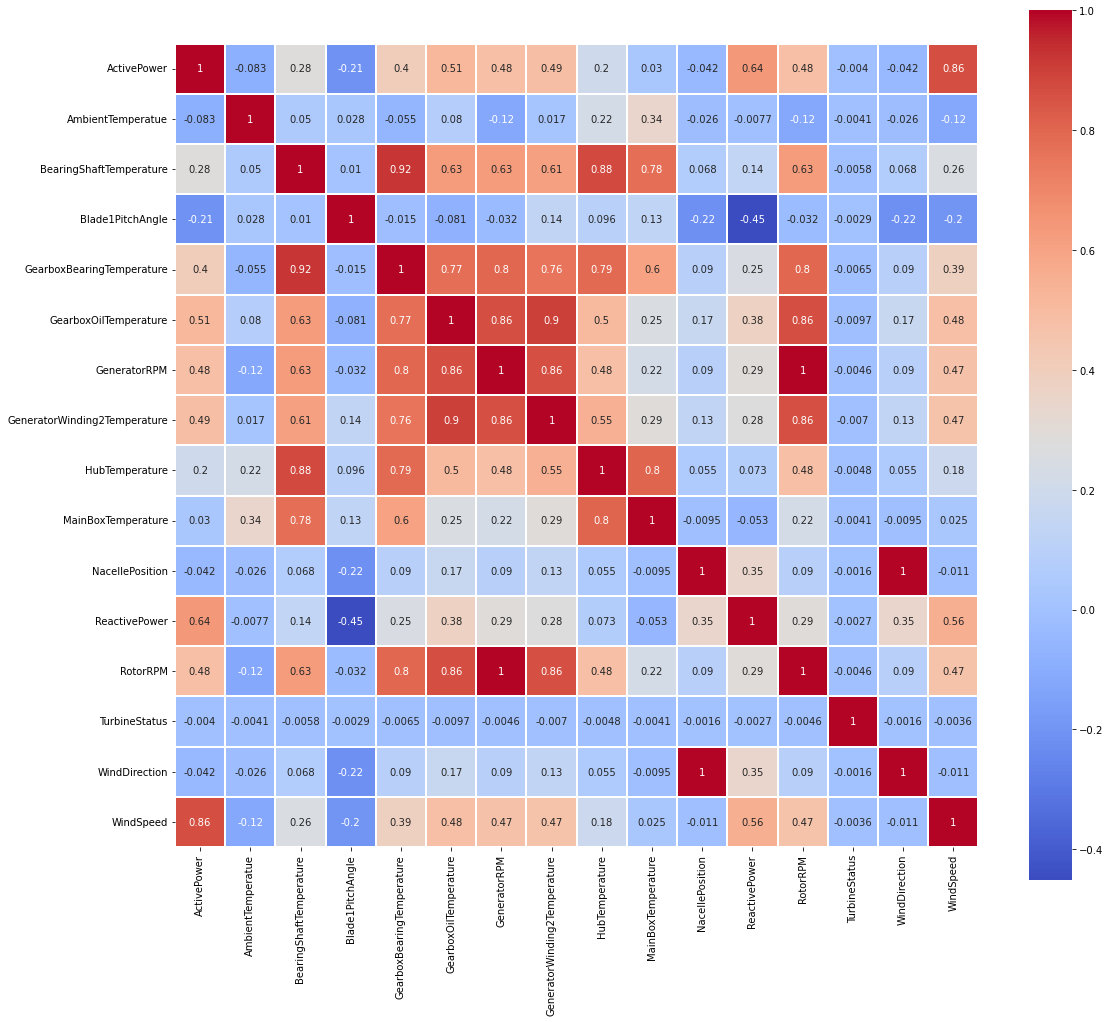

In [517]:
df.drop("GeneratorWinding1Temperature",axis=1,inplace=True)

import seaborn as sns
plt.figure(figsize=(18,16))

sns.heatmap(df.corr(),square=True,annot=True,linewidths=0.1,cmap="coolwarm")
plt.show()
    
# df['ControlBoxTemperature']

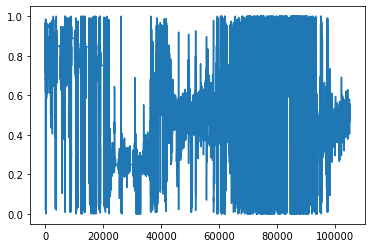

In [459]:
plt.plot(df.WindDirection)

In [487]:
df_1 = df[df.Datetime > "2019"]

In [488]:
df_1.WindDirection=np.round(df_1.WindDirection*360)

/Users/wanqingan/opt/anaconda3/lib/python3.9/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


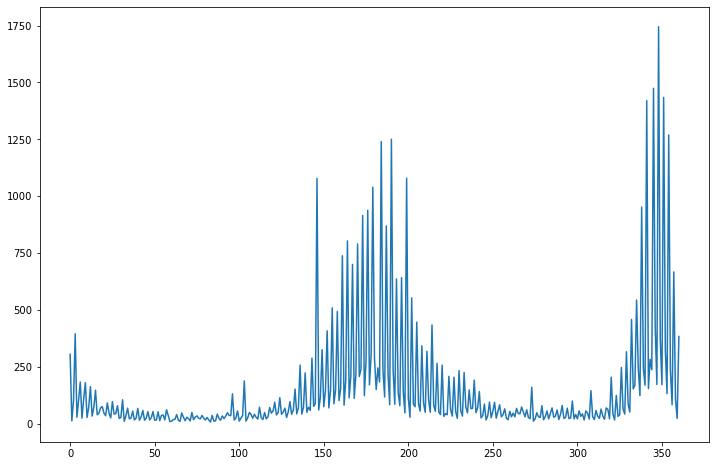

In [500]:
plt.figure(figsize=(12,8))
plt.plot(df_1.groupby('WindDirection').apply(lambda x : len(x.ActivePower)))

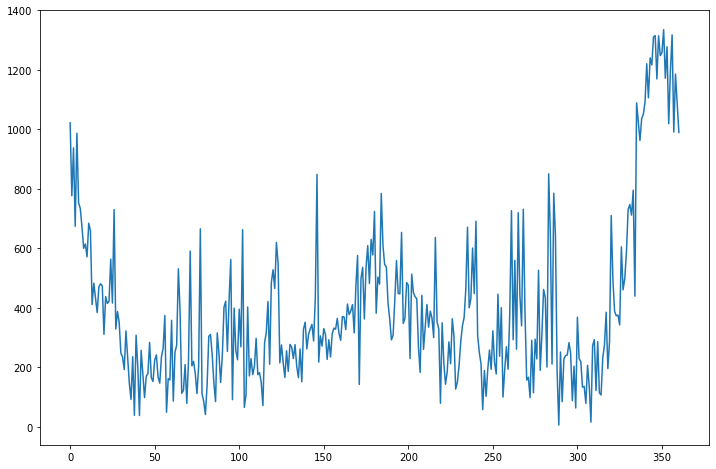

In [499]:
plt.figure(figsize=(12,8))
plt.plot(df_1.groupby('WindDirection').apply(lambda x : np.mean(x.ActivePower)))

Text(0.5, 1.0, '(b) Percentage wind power distribution in terms of wind direction')

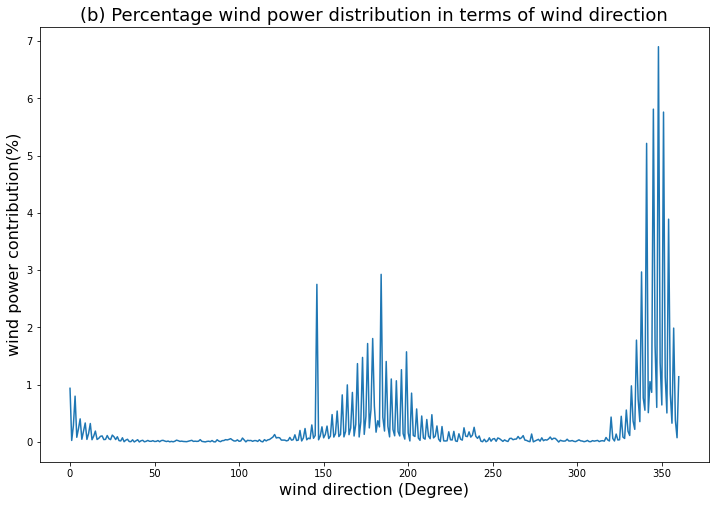

In [522]:
plt.figure(figsize=(12,8))
plt.plot(df_1.groupby('WindDirection').apply(lambda x : 100 * np.sum(x.ActivePower)/sum(df_1.ActivePower)))
plt.xlabel("wind direction (Degree)",fontsize=16)
plt.ylabel("wind power contribution(%)",fontsize=16)
plt.title('(b) Percentage wind power distribution in terms of wind direction',fontsize = 18)

Text(0.5, 1.0, '(a) Wind power in terms of wind direction')

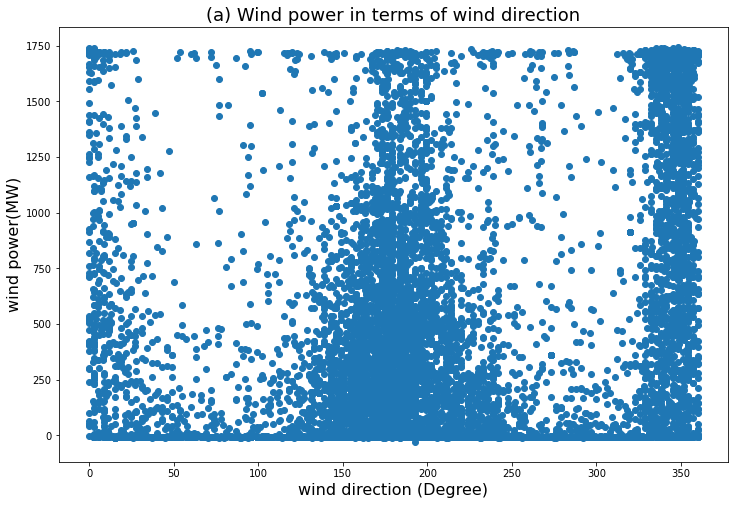

In [524]:
plt.figure(figsize=(12,8))
plt.plot(df_1['WindDirection'][::5],df_1['ActivePower'][::5],'o')
plt.xlabel("wind direction (Degree)",fontsize=16)
plt.ylabel("wind power(MW)",fontsize=16)
plt.title('(a) Wind power in terms of wind direction',fontsize = 18)

Text(0, 0.5, 'wind power(MW)')

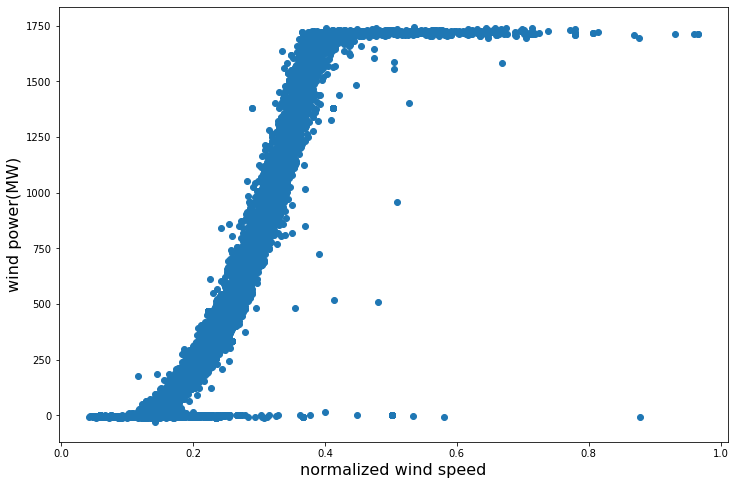

In [502]:
plt.figure(figsize=(12,8))
plt.plot(df_1['WindSpeed'][::5],df_1['ActivePower'][::5],'o')
plt.xlabel("normalized wind speed",fontsize=16)
plt.ylabel("wind power(MW)",fontsize=16)

In [316]:
datetime.strftime(df.Datetime[0],"%Y-%m-%d")

'2018-01-01'

In [360]:
df["Date"]=df.Datetime.apply(lambda x : datetime.strftime(x,"%Y-%m-%d"))

In [361]:
avg_active_power=df.groupby("Date").apply(lambda x : np.mean(x['ActivePower']))

In [378]:
avg_active_power

,Date,0
0,2018-01-01,191.951517
1,2018-01-02,337.024087
2,2018-01-03,318.712495
3,2018-01-04,362.243670
4,2018-01-05,236.690298
...,...,...
726,2019-12-28,605.775059
727,2019-12-29,596.134848
728,2019-12-30,782.315689
729,2019-12-31,746.259804


In [362]:
avg_active_power=avg_active_power.reset_index()

In [379]:
avg_active_power

,Date,0
0,2018-01-01,191.951517
1,2018-01-02,337.024087
2,2018-01-03,318.712495
3,2018-01-04,362.243670
4,2018-01-05,236.690298
...,...,...
726,2019-12-28,605.775059
727,2019-12-29,596.134848
728,2019-12-30,782.315689
729,2019-12-31,746.259804


In [388]:
avg_active_power['Date']=avg_active_power['Date'].apply(lambda x : datetime.strptime(x,"%Y-%m-%d"))

In [395]:
avg_active_power

,Date,0
0,2018-01-01,191.951517
1,2018-01-02,337.024087
2,2018-01-03,318.712495
3,2018-01-04,362.243670
4,2018-01-05,236.690298
...,...,...
726,2019-12-28,605.775059
727,2019-12-29,596.134848
728,2019-12-30,782.315689
729,2019-12-31,746.259804


Text(0, 0.5, 'Wind Power Generated(MW)')

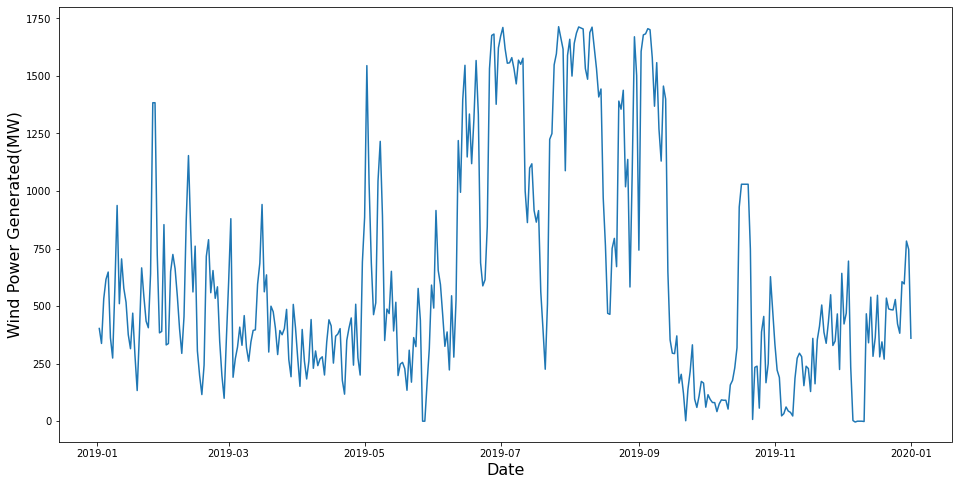

In [440]:
plt.figure(figsize=(16,8))



plt.plot(avg_active_power[avg_active_power.Date>"2019"]["Date"],avg_active_power[avg_active_power.Date>"2019"].iloc[:,1])
plt.xlabel('Date',fontsize=16)
plt.ylabel('Wind Power Generated(MW)',fontsize=16)






In [24]:
from statsmodels.tsa.arima_model import ARIMA

In [25]:
df1=df[df.Datetime>=datetime(2018,12,1)]

In [26]:
df1.reset_index(drop=True,inplace= True)

In [27]:
df1=df1[df1.Datetime<=datetime(2019,1,30)]

In [28]:
df1 = df1.iloc[::6].reset_index(drop=True)

In [49]:
windpower_adf=adfuller(df1['ActivePower'].diff()[1:])

In [57]:
import statsmodels.tsa.stattools as st

In [58]:
st.arma_order_select_ic(df1['ActivePower'], max_ar=5, max_ma=5, ic=['aic', 'bic'])

/Users/wanqingan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/wanqingan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:701: RuntimeWarning: overflow encountered in exp
  newparam

{'aic':               0             1             2             3             4  \
 0  21589.760534  20579.437335  20111.693921  19934.488017  19831.719231   
 1  19701.061627  19701.490094  19698.112644  19699.742908  19695.478526   
 2  19701.246039  19691.565182  19690.730849  19692.442307  19690.046754   
 3  19696.846328  19690.831882  19692.555777  19693.786466  19632.265418   
 4  19697.972382  19692.722578  19693.892777           NaN  19695.505969   
 5  19692.482307  19690.750446  19692.723612  19695.905158           NaN   
 
               5  
 0  19772.672004  
 1  19695.807857  
 2  19692.022172  
 3  19693.756210  
 4           NaN  
 5           NaN  ,
 'bic':               0             1             2             3             4  \
 0  21600.306719  20595.256613  20132.786292  19960.853480  19863.357786   
 1  19716.880905  19722.582464  19724.478107  19731.381464  19732.390174   
 2  19722.338409  19717.930645  19722.369404  19729.353955  19732.231495   
 3  19723.2117

In [50]:
windpower_adf

(-17.01217026471525,
 8.575688324903001e-30,
 20,
 1419,
 {'1%': -3.434966750462565,
  '5%': -2.8635789736973725,
  '10%': -2.5678555388041384},
 19314.92500626357)

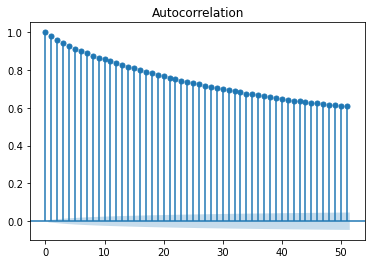

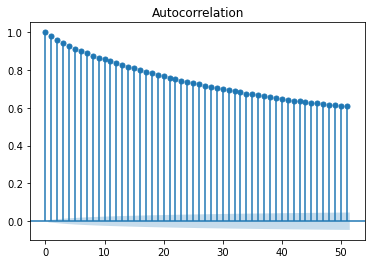

In [55]:
plot_acf(df['ActivePower'].values)

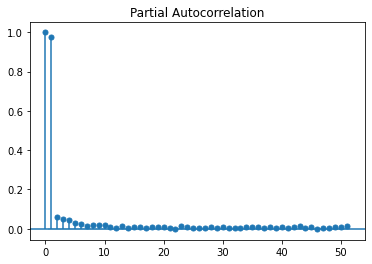

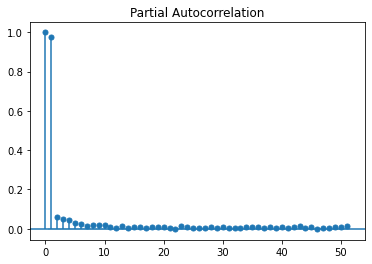

In [56]:
plot_pacf(df['ActivePower'].values)

In [59]:
forecasts= []
real_values =[]
times = []
for i in range(24,24*8):
    data = df1.ActivePower.values[i:i+24*30]
    model = ARIMA(data, (3,0,4)).fit()
    forecasts.append(model.forecast(1)[0])
    real_values.append(df1.ActivePower.values[24*30+i:24*30+(i+1)])
    times.append(df1.Datetime.values[24*30+i:(i+1)+24*30])
    

/Users/wanqingan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
 This problem is unconstrained.


** On entry to DLASCL, parameter number  4 had an illegal value
** On entry to DLASCL, parameter number  4 had an illegal value
** On entry to DLASCL, parameter number  4 had an illegal value
** On entry to DLASCL, parameter number  4 had an illegal value
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.79435D+00    |proj g|=  9.03722D-04

At iterate    5    f=  6.79434D+00    |proj g|=  1.31983D-04

At iterate   10    f=  6.79434D+00    |proj g|=  7.10542D-06

At iterate   15    f=  6.79434D+00    |proj g|=  6.23501D-05

At iterate   20    f=  6.79434D+00    |proj g|=  5.16920D-05

At iterate   25    f=  6.79434D+00    |proj g|=  1.03917D-04

At iterate   30    f=  6.79433D+00    |proj g|=  2.21956D-04

At iterate   35    f=  6.79433D+00    |proj g|=  2.75335D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of fun

 This problem is unconstrained.



At iterate   50    f=  6.79426D+00    |proj g|=  2.66454D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     51     69      1     0     0   2.665D-07   6.794D+00
  F =   6.7942636034835990     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.79416D+00    |proj g|=  8.61888D-04

At iterate    5    f=  6.79415D+00    |proj g|=  4.63629D-05

At iterate   10    f=  6.79415D+00    |proj g|=  1.93623D-05

At iterate   15    f=  6.79415D+00    |proj g|=  9.65450D-05

At iterate   20    f=  6.79415D+00    |proj g|=  1.89182D-05

At iterate   25    f=  6.79415D+00    |proj g|=  2.43983D-04

At iterate   30    f=  6.79414D+00    |proj g|=  1.35270D-04

At iterate   35    f=  6.79414D+00    |proj g|=  1.09246D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.79408D+00    |proj g|=  9.81260D-04

At iterate    5    f=  6.79406D+00    |proj g|=  1.87228D-04

At iterate   10    f=  6.79406D+00    |proj g|=  1.67866D-05

At iterate   15    f=  6.79406D+00    |proj g|=  1.75326D-04

At iterate   20    f=  6.79406D+00    |proj g|=  6.48370D-06

At iterate   25    f=  6.79406D+00    |proj g|=  4.09450D-05

At iterate   30    f=  6.79406D+00    |proj g|=  1.56408D-04

At iterate   35    f=  6.79405D+00    |proj g|=  4.13891D-05

At iterate   40    f=  6.79405D+00    |proj g|=  2.39808D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.79408D+00    |proj g|=  1.15445D-03

At iterate    5    f=  6.79405D+00    |proj g|=  2.63789D-04

At iterate   10    f=  6.79405D+00    |proj g|=  1.15463D-05

At iterate   15    f=  6.79405D+00    |proj g|=  7.23865D-05

At iterate   20    f=  6.79405D+00    |proj g|=  6.03961D-06

At iterate   25    f=  6.79405D+00    |proj g|=  1.73550D-04

At iterate   30    f=  6.79404D+00    |proj g|=  5.33795D-05

At iterate   35    f=  6.79404D+00    |proj g|=  5.32907D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.79409D+00    |proj g|=  1.14779D-03

At iterate    5    f=  6.79406D+00    |proj g|=  2.83507D-04

At iterate   10    f=  6.79406D+00    |proj g|=  5.95079D-06

At iterate   15    f=  6.79406D+00    |proj g|=  1.75859D-04

At iterate   20    f=  6.79405D+00    |proj g|=  4.38760D-05

At iterate   25    f=  6.79405D+00    |proj g|=  1.60671D-04

At iterate   30    f=  6.79405D+00    |proj g|=  2.25775D-04

At iterate   35    f=  6.79405D+00    |proj g|=  4.44089D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.79438D+00    |proj g|=  1.38076D-03

At iterate    5    f=  6.79434D+00    |proj g|=  5.90106D-04

At iterate   10    f=  6.79433D+00    |proj g|=  1.19904D-05

At iterate   15    f=  6.79433D+00    |proj g|=  1.23013D-04

At iterate   20    f=  6.79433D+00    |proj g|=  5.77316D-06

At iterate   25    f=  6.79433D+00    |proj g|=  6.71463D-05

At iterate   30    f=  6.79433D+00    |proj g|=  1.52411D-04

At iterate   35    f=  6.79433D+00    |proj g|=  7.99361D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.
/Users/wanqingan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:701: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/wanqingan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:701: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/wanqingan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:702: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/wanqingan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:702: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.79456D+00    |proj g|=  3.96581D-03

At iterate    5    f=  6.79390D+00    |proj g|=  3.42002D-03

At iterate   10    f=  6.78779D+00    |proj g|=  6.00409D-03

At iterate   15    f=  6.78658D+00    |proj g|=  8.64491D-03

At iterate   20    f=  6.78427D+00    |proj g|=  8.97096D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   25    f=  6.78386D+00    |proj g|=  3.20144D-03

At iterate   30    f=  6.78381D+00    |proj g|=  2.27303D-03

At iterate   35    f=  6.78381D+00    |proj g|=  3.20801D-03

At iterate   40    f=  6.78380D+00    |proj g|=  3.46834D-03
  ys=-6.141E-07  -gs= 1.220E-06 BFGS update SKIPPED

At iterate   45    f=  6.78380D+00    |proj g|=  2.03144D-03

At iterate   50    f=  6.78380D+00    |proj g|=  3.22329D-03

At iterate   55    f=  6.78380D+00    |proj g|=  4.01377D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     58    211      3     1     0   5.130D-03   6.784D+00
  F =   6.7837972945019223     

ABNORMAL_TERMINATION_IN_LNSRCH                              


/Users/wanqingan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.79605D+00    |proj g|=  2.56719D-03

At iterate    5    f=  6.79597D+00    |proj g|=  7.31859D-04

At iterate   10    f=  6.79596D+00    |proj g|=  2.44516D-04

At iterate   15    f=  6.79593D+00    |proj g|=  6.62759D-04

At iterate   20    f=  6.79593D+00    |proj g|=  5.68434D-06

At iterate   25    f=  6.79593D+00    |proj g|=  1.15463D-05

At iterate   30    f=  6.79593D+00    |proj g|=  1.80389D-04

At iterate   35    f=  6.79593D+00    |proj g|=  2.68496D-04

At iterate   40    f=  6.79593D+00    |proj g|=  3.19744D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.79488D+00    |proj g|=  2.61249D-03

At iterate    5    f=  6.79461D+00    |proj g|=  6.93579D-04

At iterate   10    f=  6.79457D+00    |proj g|=  6.38689D-04

At iterate   15    f=  6.79415D+00    |proj g|=  8.21831D-04

At iterate   20    f=  6.79414D+00    |proj g|=  6.00409D-05

At iterate   25    f=  6.79414D+00    |proj g|=  2.51354D-05

At iterate   30    f=  6.79414D+00    |proj g|=  3.55893D-04

At iterate   35    f=  6.79412D+00    |proj g|=  7.87814D-04

At iterate   40    f=  6.79412D+00    |proj g|=  1.86517D-05

At iterate   45    f=  6.79412D+00    |proj g|=  6.21725D-07


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     49     69      1     0     0   1.776D-07   6.794D+00
  F =   6.7941181229581158     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.80367D+00    |proj g|=  3.02860D-03


 This problem is unconstrained.



At iterate    5    f=  6.80131D+00    |proj g|=  1.68222D-02

At iterate   10    f=  6.79559D+00    |proj g|=  2.97531D-03

At iterate   15    f=  6.79542D+00    |proj g|=  4.25615D-04

At iterate   20    f=  6.79521D+00    |proj g|=  2.46487D-03

At iterate   25    f=  6.79499D+00    |proj g|=  4.28102D-05

At iterate   30    f=  6.79499D+00    |proj g|=  9.00613D-05

At iterate   35    f=  6.79497D+00    |proj g|=  7.37721D-04

At iterate   40    f=  6.79494D+00    |proj g|=  5.77316D-05

At iterate   45    f=  6.79494D+00    |proj g|=  1.06581D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     49     66   

 This problem is unconstrained.



At iterate    5    f=  6.79446D+00    |proj g|=  4.49685D-04

At iterate   10    f=  6.79445D+00    |proj g|=  6.96332D-04

At iterate   15    f=  6.79413D+00    |proj g|=  1.52252D-03

At iterate   20    f=  6.79411D+00    |proj g|=  1.63958D-04

At iterate   25    f=  6.79411D+00    |proj g|=  4.97380D-06

At iterate   30    f=  6.79411D+00    |proj g|=  5.34683D-05

At iterate   35    f=  6.79410D+00    |proj g|=  2.14939D-05

At iterate   40    f=  6.79410D+00    |proj g|=  2.93099D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     40     54      1     0     0   2.931D-06   6.794D+00
  F =   6.79410120488

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.78983D+00    |proj g|=  1.50049D-03

At iterate    5    f=  6.78976D+00    |proj g|=  5.51115D-04

At iterate   10    f=  6.78975D+00    |proj g|=  1.20792D-04

At iterate   15    f=  6.78973D+00    |proj g|=  8.51141D-04

At iterate   20    f=  6.78973D+00    |proj g|=  1.66089D-05

At iterate   25    f=  6.78973D+00    |proj g|=  4.52971D-06

At iterate   30    f=  6.78973D+00    |proj g|=  1.00009D-04

At iterate   35    f=  6.78973D+00    |proj g|=  6.39488D-06

At iterate   40    f=  6.78973D+00    |proj g|=  1.55431D-05

At iterate   45    f=  6.78973D+00    |proj g|=  6.03961D-06

At iterate   50    f=  6.78973D+00    |proj g|=  4.44089D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate   45    f=  6.78935D+00    |proj g|=  4.44089D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     48     69      1     1     0   8.882D-08   6.789D+00
  F =   6.7893490642851893     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.78879D+00    |proj g|=  2.06128D-03

At iterate    5    f=  6.78868D+00    |proj g|=  1.78533D-03

At iterate   10    f=  6.78867D+00    |proj g|=  2.27995D-04

At iterate   15    f=  6.78861D+00    |proj g|=  3.27827D-04

At iterate   20    f=  6.78861D+00    |proj g|=  6.83897D-06

At iterate   25    f=  6.78861D+00    |proj g|=  8.75744D-05

At iterate   30    f=  6.78861D+00    |proj g|=  5.38414D-04

At iterate   35    f=  6.78861D+00    |proj g|=  7.16760D-05

At iterate   40    f=  6.78861D+00    |proj g|=  4.61853D-06

At iterate   45    f=  6.78861D+00    |proj g|=  2.66454D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.79210D+00    |proj g|=  1.32498D-03

At iterate    5    f=  6.79209D+00    |proj g|=  6.66134D-05

At iterate   10    f=  6.79209D+00    |proj g|=  2.93099D-06

At iterate   15    f=  6.79209D+00    |proj g|=  2.04281D-06

At iterate   20    f=  6.79209D+00    |proj g|=  4.48530D-05

At iterate   25    f=  6.79209D+00    |proj g|=  2.34479D-05

At iterate   30    f=  6.79208D+00    |proj g|=  3.41949D-05

At iterate   35    f=  6.79208D+00    |proj g|=  3.28626D-06

At iterate   40    f=  6.79208D+00    |proj g|=  7.99361D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     43     60      1     0     0   8.882D-08   6.791D+00
  F =   6.7911800173040708     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.79153D+00    |proj g|=  1.58495D-03


 This problem is unconstrained.



At iterate    5    f=  6.79150D+00    |proj g|=  7.68896D-04

At iterate   10    f=  6.79133D+00    |proj g|=  1.57332D-03

At iterate   15    f=  6.79126D+00    |proj g|=  8.39329D-05

At iterate   20    f=  6.79126D+00    |proj g|=  4.44089D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     22     29      1     0     0   1.776D-07   6.791D+00
  F =   6.7912642126507796     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.78983D+00    |proj g|=  1.09939D-03

At iterate    5    f=  6.78980D+00    |proj g|=  1.30989D-03

At iterate   10    f=  6.78972D+00    |proj g|=  1.78071D-03

At iterate   15    f=  6.78957D+00    |proj g|=  3.93463D-04

At iterate   20    f=  6.78957D+00    |proj g|=  2.93099D-06

At iterate   25    f=  6.78957D+00    |proj g|=  5.59552D-06

At iterate   30    f=  6.78957D+00    |proj g|=  1.02762D-04

At iterate   35    f=  6.78957D+00    |proj g|=  9.14824D-06

At iterate   40    f=  6.78957D+00    |proj g|=  9.76996D-07

At iterate   45    f=  6.78957D+00    |proj g|=  2.66454D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.



At iterate    5    f=  6.78908D+00    |proj g|=  1.43716D-03

At iterate   10    f=  6.78906D+00    |proj g|=  2.92655D-04

At iterate   15    f=  6.78904D+00    |proj g|=  2.48779D-04

At iterate   20    f=  6.78904D+00    |proj g|=  4.88498D-06

At iterate   25    f=  6.78904D+00    |proj g|=  9.08607D-05

At iterate   30    f=  6.78904D+00    |proj g|=  2.60414D-04

At iterate   35    f=  6.78903D+00    |proj g|=  1.41220D-05

At iterate   40    f=  6.78903D+00    |proj g|=  6.21725D-07

At iterate   45    f=  6.78903D+00    |proj g|=  2.66454D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     45     58   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.78884D+00    |proj g|=  1.41442D-03

At iterate    5    f=  6.78880D+00    |proj g|=  3.16369D-04

At iterate   10    f=  6.78879D+00    |proj g|=  1.37934D-04

At iterate   15    f=  6.78878D+00    |proj g|=  3.75433D-04

At iterate   20    f=  6.78878D+00    |proj g|=  3.90798D-06

At iterate   25    f=  6.78878D+00    |proj g|=  7.71827D-05

At iterate   30    f=  6.78878D+00    |proj g|=  9.92983D-05

At iterate   35    f=  6.78878D+00    |proj g|=  6.12843D-06

At iterate   40    f=  6.78878D+00    |proj g|=  5.32907D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.79058D+00    |proj g|=  1.22489D-03

At iterate    5    f=  6.79057D+00    |proj g|=  1.60671D-04

At iterate   10    f=  6.79057D+00    |proj g|=  1.26121D-05

At iterate   15    f=  6.79057D+00    |proj g|=  1.31628D-04

At iterate   20    f=  6.79057D+00    |proj g|=  4.44089D-07

At iterate   25    f=  6.79057D+00    |proj g|=  4.44089D-07

At iterate   30    f=  6.79057D+00    |proj g|=  3.19744D-06

At iterate   35    f=  6.79057D+00    |proj g|=  9.32587D-06

At iterate   40    f=  6.79057D+00    |proj g|=  1.90958D-05

At iterate   45    f=  6.79057D+00    |proj g|=  5.24025D-06

At iterate   50    f=  6.79057D+00    |proj g|=  3.46390D-06

At iterate   55    f=  6.79057D+00    |proj g|=  2.66454D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function ev

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.79071D+00    |proj g|=  1.52571D-03

At iterate    5    f=  6.79070D+00    |proj g|=  3.79696D-04

At iterate   10    f=  6.79070D+00    |proj g|=  1.11910D-05

At iterate   15    f=  6.79070D+00    |proj g|=  4.55636D-05

At iterate   20    f=  6.79070D+00    |proj g|=  9.23706D-06

At iterate   25    f=  6.79070D+00    |proj g|=  9.13047D-05

At iterate   30    f=  6.79069D+00    |proj g|=  1.55076D-04

At iterate   35    f=  6.79069D+00    |proj g|=  1.03295D-04

At iterate   40    f=  6.79069D+00    |proj g|=  2.93099D-06

At iterate   45    f=  6.79069D+00    |proj g|=  4.44089D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.79090D+00    |proj g|=  2.46443D-03

At iterate    5    f=  6.79078D+00    |proj g|=  1.23332D-03

At iterate   10    f=  6.79076D+00    |proj g|=  4.09894D-04

At iterate   15    f=  6.79072D+00    |proj g|=  4.56613D-04

At iterate   20    f=  6.79071D+00    |proj g|=  5.50671D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     24     33      1     0     0   2.665D-07   6.791D+00
  F =   6.7907129691031889     

CONVERG

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.79315D+00    |proj g|=  2.23501D-03

At iterate    5    f=  6.79310D+00    |proj g|=  4.44622D-04

At iterate   10    f=  6.79310D+00    |proj g|=  3.03757D-05

At iterate   15    f=  6.79310D+00    |proj g|=  8.82938D-04

At iterate   20    f=  6.79302D+00    |proj g|=  1.68804D-02

At iterate   25    f=  6.79188D+00    |proj g|=  1.53726D-03

At iterate   30    f=  6.79185D+00    |proj g|=  4.04032D-04

At iterate   35    f=  6.79185D+00    |proj g|=  8.88178D-06

At iterate   40    f=  6.79185D+00    |proj g|=  1.10667D-04

At iterate   45    f=  6.79184D+00    |proj g|=  6.78568D-04

At iterate   50    f=  6.79183D+00    |proj g|=  3.90799D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.78945D+00    |proj g|=  1.44080D-03

At iterate    5    f=  6.78942D+00    |proj g|=  5.14166D-04

At iterate   10    f=  6.78942D+00    |proj g|=  1.66089D-05

At iterate   15    f=  6.78942D+00    |proj g|=  1.60938D-04

At iterate   20    f=  6.78942D+00    |proj g|=  1.38556D-05

At iterate   25    f=  6.78941D+00    |proj g|=  1.98774D-04

At iterate   30    f=  6.78941D+00    |proj g|=  6.28919D-04

At iterate   35    f=  6.78941D+00    |proj g|=  4.17444D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.78894D+00    |proj g|=  1.07496D-03

At iterate    5    f=  6.78893D+00    |proj g|=  4.95604D-05

At iterate   10    f=  6.78893D+00    |proj g|=  1.14042D-04

At iterate   15    f=  6.78893D+00    |proj g|=  8.43769D-06

At iterate   20    f=  6.78893D+00    |proj g|=  6.34159D-05

At iterate   25    f=  6.78893D+00    |proj g|=  8.44036D-04

At iterate   30    f=  6.78892D+00    |proj g|=  3.83693D-05

At iterate   35    f=  6.78892D+00    |proj g|=  1.59872D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.80382D+00    |proj g|=  1.19823D-02

At iterate    5    f=  6.80321D+00    |proj g|=  3.35998D-03

At iterate   10    f=  6.80127D+00    |proj g|=  6.44267D-03

At iterate   15    f=  6.80083D+00    |proj g|=  2.08606D-03

At iterate   20    f=  6.80080D+00    |proj g|=  1.05551D-03

At iterate   25    f=  6.80020D+00    |proj g|=  1.44371D-02

At iterate   30    f=  6.79298D+00    |proj g|=  4.02736D-03

At iterate   35    f=  6.79217D+00    |proj g|=  4.10854D-03

At iterate   40    f=  6.79157D+00    |proj g|=  1.25500D-04

At iterate   45    f=  6.79157D+00    |proj g|=  1.09246D-04

At iterate   50    f=  6.79157D+00    |proj g|=  1.60760D-05

At iterate   55    f=  6.79157D+00    |proj g|=  2.77112D-05

At iterate   60    f=  6.79157D+00    |proj g|=  1.97797D-04

At iterate   65    f=  6.7

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.80350D+00    |proj g|=  2.09248D-02

At iterate    5    f=  6.80147D+00    |proj g|=  1.78790D-03

At iterate   10    f=  6.80133D+00    |proj g|=  5.17542D-04

At iterate   15    f=  6.80133D+00    |proj g|=  3.23297D-05

At iterate   20    f=  6.80133D+00    |proj g|=  1.98330D-04

At iterate   25    f=  6.80133D+00    |proj g|=  2.02389D-03

At iterate   30    f=  6.80125D+00    |proj g|=  6.61196D-03

At iterate   35    f=  6.80068D+00    |proj g|=  3.43583D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   40    f=  6.79501D+00    |proj g|=  5.55591D-03

At iterate   45    f=  6.79231D+00    |proj g|=  1.14353D-03

At iterate   50    f=  6.79205D+00    |proj g|=  2.25571D-03

At iterate   55    f=  6.79192D+00    |proj g|=  4.39924D-03

At iterate   60    f=  6.79171D+00    |proj g|=  2.11564D-04

At iterate   65    f=  6.79171D+00    |proj g|=  5.64881D-05

At iterate   70    f=  6.79171D+00    |proj g|=  3.01980D-06

At iterate   75    f=  6.79171D+00    |proj g|=  2.17604D-05

At iterate   80    f=  6.79171D+00    |proj g|=  4.85834D-05

At iterate   85    f=  6.79171D+00    |proj g|=  6.93667D-05

At iterate   90    f=  6.79170D+00    |proj g|=  2.72671D-05

At iterate   95    f=  6.79170D+00    |proj g|=  2.57572D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.79943D+00    |proj g|=  1.53437D-02

At iterate    5    f=  6.79804D+00    |proj g|=  8.13305D-04

At iterate   10    f=  6.79799D+00    |proj g|=  1.11200D-04

At iterate   15    f=  6.79799D+00    |proj g|=  5.01110D-04

At iterate   20    f=  6.79797D+00    |proj g|=  4.57678D-03

At iterate   25    f=  6.79773D+00    |proj g|=  6.51692D-03

At iterate   30    f=  6.79737D+00    |proj g|=  1.15898D-02

At iterate   35    f=  6.79474D+00    |proj g|=  2.10068D-02

At iterate   40    f=  6.79042D+00    |proj g|=  8.00640D-03

At iterate   45    f=  6.78923D+00    |proj g|=  1.70886D-03

At iterate   50    f=  6.78881D+00    |proj g|=  6.76259D-04

At iterate   55    f=  6.78845D+00    |proj g|=  6.19229D-03

At iterate   60    f=  6.78821D+00    |proj g|=  2.32969D-04

At iterate   65    f=  6.7

/Users/wanqingan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.78357D+00    |proj g|=  6.43654D-03

At iterate    5    f=  6.78310D+00    |proj g|=  3.09397D-03

At iterate   10    f=  6.78305D+00    |proj g|=  4.67271D-04

At iterate   15    f=  6.78297D+00    |proj g|=  3.42926D-04

At iterate   20    f=  6.78297D+00    |proj g|=  1.45661D-05

At iterate   25    f=  6.78297D+00    |proj g|=  2.21778D-04

At iterate   30    f=  6.78295D+00    |proj g|=  6.97309D-04

At iterate   35    f=  6.78294D+00    |proj g|=  1.75859D-05

At iterate   40    f=  6.78294D+00    |proj g|=  2.66454D-07

At iterate   45    f=  6.78294D+00    |proj g|=  4.44089D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.77687D+00    |proj g|=  3.18847D-03

At iterate    5    f=  6.77677D+00    |proj g|=  9.95559D-04

At iterate   10    f=  6.77676D+00    |proj g|=  2.19380D-04

At iterate   15    f=  6.77641D+00    |proj g|=  5.17568D-03

At iterate   20    f=  6.77586D+00    |proj g|=  6.20570D-04

At iterate   25    f=  6.77585D+00    |proj g|=  1.98952D-05

At iterate   30    f=  6.77585D+00    |proj g|=  1.34115D-05

At iterate   35    f=  6.77585D+00    |proj g|=  2.03570D-04

At iterate   40    f=  6.77585D+00    |proj g|=  1.90958D-05

At iterate   45    f=  6.77585D+00    |proj g|=  5.06262D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.76907D+00    |proj g|=  1.22364D-03

At iterate    5    f=  6.76904D+00    |proj g|=  7.57172D-04

At iterate   10    f=  6.76897D+00    |proj g|=  1.63141D-03

At iterate   15    f=  6.76886D+00    |proj g|=  1.86073D-04

At iterate   20    f=  6.76886D+00    |proj g|=  7.81597D-06

At iterate   25    f=  6.76886D+00    |proj g|=  1.15463D-06

At iterate   30    f=  6.76886D+00    |proj g|=  8.70415D-06

At iterate   35    f=  6.76886D+00    |proj g|=  2.58460D-05

At iterate   40    f=  6.76886D+00    |proj g|=  7.10543D-06

At iterate   45    f=  6.76886D+00    |proj g|=  1.42109D-06

At iterate   50    f=  6.76886D+00    |proj g|=  2.66454D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.76899D+00    |proj g|=  5.02354D-04

At iterate    5    f=  6.76899D+00    |proj g|=  1.25944D-04

At iterate   10    f=  6.76899D+00    |proj g|=  1.20881D-04

At iterate   15    f=  6.76898D+00    |proj g|=  6.49703D-04

At iterate   20    f=  6.76898D+00    |proj g|=  2.93099D-06

At iterate   25    f=  6.76898D+00    |proj g|=  3.45501D-05

At iterate   30    f=  6.76898D+00    |proj g|=  7.99361D-05

At iterate   35    f=  6.76898D+00    |proj g|=  4.47642D-05

At iterate   40    f=  6.76898D+00    |proj g|=  4.52971D-06

At iterate   45    f=  6.76898D+00    |proj g|=  1.50990D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.



At iterate    5    f=  6.76925D+00    |proj g|=  2.44160D-04

At iterate   10    f=  6.76924D+00    |proj g|=  5.68434D-06

At iterate   15    f=  6.76924D+00    |proj g|=  4.70735D-05

At iterate   20    f=  6.76924D+00    |proj g|=  7.46070D-06

At iterate   25    f=  6.76924D+00    |proj g|=  1.79945D-04

At iterate   30    f=  6.76924D+00    |proj g|=  1.07025D-04

At iterate   35    f=  6.76924D+00    |proj g|=  3.37508D-06

At iterate   40    f=  6.76924D+00    |proj g|=  1.77636D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     44     59      1     0     0   2.665D-07   6.769D+00
  F =   6.76924130957

 This problem is unconstrained.



At iterate   45    f=  6.76905D+00    |proj g|=  3.55271D-07

At iterate   50    f=  6.76905D+00    |proj g|=  2.13163D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     52     76      1     0     0   1.599D-06   6.769D+00
  F =   6.7690484609677162     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.76997D+00    |proj g|=  5.38236D-04

At iterate    5    f=  6.76997D+00    |proj g|=  7.62945D-05

At iter

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     39     60      1     0     0   1.243D-06   6.770D+00
  F =   6.7699662546018899     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.77089D+00    |proj g|=  6.56541D-04

At iterate    5    f=  6.77089D+00    |proj g|=  8.64198D-05

At iterate   10    f=  6.77089D+00    |proj g|=  1.46549D-05

At iterate   15    f=  6.77088D+00    |proj g|=  1.62270D-04

At iter

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.77128D+00    |proj g|=  5.57598D-04

At iterate    5    f=  6.77128D+00    |proj g|=  2.08367D-04

At iterate   10    f=  6.77127D+00    |proj g|=  2.64233D-04

At iterate   15    f=  6.77127D+00    |proj g|=  3.40172D-05

At iterate   20    f=  6.77127D+00    |proj g|=  2.66453D-07

At iterate   25    f=  6.77127D+00    |proj g|=  1.42109D-06

At iterate   30    f=  6.77127D+00    |proj g|=  3.55271D-06

At iterate   35    f=  6.77127D+00    |proj g|=  1.47438D-05

At iterate   40    f=  6.77127D+00    |proj g|=  5.50671D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.



At iterate   45    f=  6.77177D+00    |proj g|=  3.01981D-06

At iterate   50    f=  6.77177D+00    |proj g|=  7.99361D-07

At iterate   55    f=  6.77177D+00    |proj g|=  2.66454D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     59     82      1     0     0   2.665D-07   6.772D+00
  F =   6.7717739802175094     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.77156D+00    |proj g|=  8.89511D-04

At iterate    5    f=  6.77155D+00    |proj g|=  2.57572D-04

At iterate   10    f=  6.77155D+00    |proj g|=  4.43201D-05

At iterate   15    f=  6.77155D+00    |proj g|=  1.16973D-04

At iterate   20    f=  6.77155D+00    |proj g|=  1.77636D-06

At iterate   25    f=  6.77155D+00    |proj g|=  2.26485D-05

At iterate   30    f=  6.77155D+00    |proj g|=  1.05960D-04

At iterate   35    f=  6.77155D+00    |proj g|=  1.77636D-06

At iterate   40    f=  6.77155D+00    |proj g|=  3.55271D-07

At iterate   45    f=  6.77155D+00    |proj g|=  2.66454D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.77184D+00    |proj g|=  1.71116D-03

At iterate    5    f=  6.77182D+00    |proj g|=  8.67839D-04

At iterate   10    f=  6.77177D+00    |proj g|=  1.23004D-03

At iterate   15    f=  6.77165D+00    |proj g|=  2.73381D-04

At iterate   20    f=  6.77165D+00    |proj g|=  3.37508D-06

At iterate   25    f=  6.77165D+00    |proj g|=  7.24754D-05

At iterate   30    f=  6.77165D+00    |proj g|=  1.06493D-04

At iterate   35    f=  6.77165D+00    |proj g|=  1.71418D-05

At iterate   40    f=  6.77165D+00    |proj g|=  1.77636D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.



At iterate   50    f=  6.77143D+00    |proj g|=  1.77636D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     51     67      1     0     0   1.776D-07   6.771D+00
  F =   6.7714255647735957     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.77135D+00    |proj g|=  2.44604D-03

At iterate    5    f=  6.77126D+00    |proj g|=  1.51044D-03

At iterate   10    f=  6.77109D+00    |proj g|=  3.92326D-03

At iterate   15    f=  6.77103D+00    |proj g|=  2.78000D-05

At iterate   20    f=  6.77103D+00    |proj g|=  7.28306D-06

At iterate   25    f=  6.77103D+00    |proj g|=  3.33955D-05

At iterate   30    f=  6.77103D+00    |proj g|=  1.41132D-04

At iterate   35    f=  6.77103D+00    |proj g|=  9.50351D-06

At iterate   40    f=  6.77103D+00    |proj g|=  2.48690D-06

At iterate   45    f=  6.77103D+00    |proj g|=  2.66454D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.77133D+00    |proj g|=  2.95461D-03

At iterate    5    f=  6.77106D+00    |proj g|=  2.68985D-03

At iterate   10    f=  6.77102D+00    |proj g|=  4.50040D-04

At iterate   15    f=  6.77094D+00    |proj g|=  5.03508D-04

At iterate   20    f=  6.77094D+00    |proj g|=  9.23705D-06

At iterate   25    f=  6.77093D+00    |proj g|=  1.44773D-04

At iterate   30    f=  6.77092D+00    |proj g|=  5.57066D-04

At iterate   35    f=  6.77092D+00    |proj g|=  4.68958D-05

At iterate   40    f=  6.77092D+00    |proj g|=  9.59233D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.77194D+00    |proj g|=  1.53024D-03

At iterate    5    f=  6.77189D+00    |proj g|=  8.23164D-04

At iterate   10    f=  6.77179D+00    |proj g|=  2.37792D-03

At iterate   15    f=  6.77135D+00    |proj g|=  5.78826D-04

At iterate   20    f=  6.77135D+00    |proj g|=  8.88178D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     23     30      1     0     0   3.553D-07   6.771D+00
  F =   6.7713456843260538     

CONVERG

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.76587D+00    |proj g|=  7.49445D-04

At iterate    5    f=  6.76586D+00    |proj g|=  1.23368D-04

At iterate   10    f=  6.76586D+00    |proj g|=  1.05693D-04

At iterate   15    f=  6.76585D+00    |proj g|=  4.19842D-04

At iterate   20    f=  6.76585D+00    |proj g|=  1.24345D-06

At iterate   25    f=  6.76585D+00    |proj g|=  9.85878D-06

At iterate   30    f=  6.76585D+00    |proj g|=  3.87246D-05

At iterate   35    f=  6.76585D+00    |proj g|=  1.12799D-05

At iterate   40    f=  6.76585D+00    |proj g|=  6.21725D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     38     55      1     0     0   2.665D-07   6.766D+00
  F =   6.7655238649295510     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.76536D+00    |proj g|=  2.39710D-03

At iterate    5    f=  6.76534D+00    |proj g|=  5.11413D-04

At iterate   10    f=  6.76534D+00    |proj g|=  4.54747D-05

At iterate   15    f=  6.76533D+00    |proj g|=  3.66462D-04

At iter

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.76562D+00    |proj g|=  4.94573D-03

At iterate    5    f=  6.76546D+00    |proj g|=  6.91980D-04

At iterate   10    f=  6.76544D+00    |proj g|=  2.02860D-04

At iterate   15    f=  6.76542D+00    |proj g|=  1.49205D-03

At iterate   20    f=  6.76541D+00    |proj g|=  3.05533D-05

At iterate   25    f=  6.76541D+00    |proj g|=  8.97060D-06

At iterate   30    f=  6.76541D+00    |proj g|=  1.33671D-04

At iterate   35    f=  6.76540D+00    |proj g|=  1.84475D-04

At iterate   40    f=  6.76540D+00    |proj g|=  2.34479D-05

At iterate   45    f=  6.76540D+00    |proj g|=  7.99361D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.



At iterate    5    f=  6.76525D+00    |proj g|=  6.47749D-04

At iterate   10    f=  6.76499D+00    |proj g|=  4.89990D-03

At iterate   15    f=  6.76477D+00    |proj g|=  1.39888D-04

At iterate   20    f=  6.76477D+00    |proj g|=  2.49578D-05

At iterate   25    f=  6.76477D+00    |proj g|=  3.55271D-07

At iterate   30    f=  6.76477D+00    |proj g|=  5.95080D-06

At iterate   35    f=  6.76477D+00    |proj g|=  3.28626D-06

At iterate   40    f=  6.76477D+00    |proj g|=  1.85629D-05

At iterate   45    f=  6.76477D+00    |proj g|=  3.01981D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     49     64   

 This problem is unconstrained.



At iterate    5    f=  6.76252D+00    |proj g|=  8.73079D-05

At iterate   10    f=  6.76252D+00    |proj g|=  8.80185D-05

At iterate   15    f=  6.76252D+00    |proj g|=  5.32019D-05

At iterate   20    f=  6.76252D+00    |proj g|=  5.32907D-07

At iterate   25    f=  6.76252D+00    |proj g|=  2.66454D-07

At iterate   30    f=  6.76252D+00    |proj g|=  1.77636D-06

At iterate   35    f=  6.76252D+00    |proj g|=  6.21725D-07

At iterate   40    f=  6.76252D+00    |proj g|=  2.78000D-05

At iterate   45    f=  6.76252D+00    |proj g|=  7.81597D-06

At iterate   50    f=  6.76252D+00    |proj g|=  2.22045D-06

At iterate   55    f=  6.76252D+00    |proj g|=  6.21725D-07

At iterate   60    f=  6.76252D+00    |proj g|=  2.66454D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.76412D+00    |proj g|=  7.18083D-03

At iterate    5    f=  6.76284D+00    |proj g|=  4.66853D-03

At iterate   10    f=  6.76263D+00    |proj g|=  1.73817D-03

At iterate   15    f=  6.76216D+00    |proj g|=  3.39089D-03

At iterate   20    f=  6.76213D+00    |proj g|=  1.64313D-05

At iterate   25    f=  6.76213D+00    |proj g|=  3.89022D-05

At iterate   30    f=  6.76213D+00    |proj g|=  1.50395D-03

At iterate   35    f=  6.76211D+00    |proj g|=  2.05169D-05

At iterate   40    f=  6.76211D+00    |proj g|=  1.06581D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.75940D+00    |proj g|=  3.58318D-03

At iterate    5    f=  6.75935D+00    |proj g|=  1.10134D-04

At iterate   10    f=  6.75934D+00    |proj g|=  6.98730D-04

At iterate   15    f=  6.75934D+00    |proj g|=  7.56728D-05

At iterate   20    f=  6.75934D+00    |proj g|=  2.13163D-06

At iterate   25    f=  6.75934D+00    |proj g|=  6.01297D-05

At iterate   30    f=  6.75934D+00    |proj g|=  2.33591D-05

At iterate   35    f=  6.75934D+00    |proj g|=  2.39808D-06

At iterate   40    f=  6.75934D+00    |proj g|=  4.44089D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.75497D+00    |proj g|=  2.48521D-03

At iterate    5    f=  6.75494D+00    |proj g|=  3.58202D-04

At iterate   10    f=  6.75493D+00    |proj g|=  4.20641D-04

At iterate   15    f=  6.75491D+00    |proj g|=  2.98428D-05

At iterate   20    f=  6.75491D+00    |proj g|=  1.25233D-05

At iterate   25    f=  6.75491D+00    |proj g|=  1.95843D-04

At iterate   30    f=  6.75491D+00    |proj g|=  2.41140D-04

At iterate   35    f=  6.75491D+00    |proj g|=  1.58984D-05

At iterate   40    f=  6.75491D+00    |proj g|=  2.93099D-06


 This problem is unconstrained.



At iterate   45    f=  6.75491D+00    |proj g|=  2.66454D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     45     58      1     0     0   2.665D-07   6.755D+00
  F =   6.7549059308936803     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.75504D+00    |proj g|=  2.00622D-03

At iterate    5    f=  6.75499D+00    |proj g|=  9.47509D-04

At iterate   10    f=  6.75490D+00    |proj g|=  1.44915D-03

At iterate   15    f=  6.75476D+00    |proj g|=  2.11386D-04

At iterate   20    f=  6.75476D+00    |proj g|=  2.04281D-06

At iterate   25    f=  6.75476D+00    |proj g|=  5.06262D-06

At iterate   30    f=  6.75476D+00    |proj g|=  6.99885D-05

At iterate   35    f=  6.75476D+00    |proj g|=  3.55271D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.



At iterate   30    f=  6.74270D+00    |proj g|=  7.63771D-03

At iterate   35    f=  6.74267D+00    |proj g|=  1.81419D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


  ys=-6.653E-11  -gs= 1.416E-10 BFGS update SKIPPED

At iterate   40    f=  6.74267D+00    |proj g|=  1.58158D-03
  ys=-6.540E-13  -gs= 2.408E-12 BFGS update SKIPPED

At iterate   45    f=  6.74267D+00    |proj g|=  1.17995D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   50    f=  6.74267D+00    |proj g|=  1.78373D-03

At iterate   55    f=  6.74267D+00    |proj g|=  8.05933D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   60    f=  6.74267D+00    |proj g|=  1.88045D-03
  ys=-2.209E-19  -gs= 8.586E-19 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     61    258      5     3     0   1.880D-03   6.743D+00
  F =   6.7426665914855635     

ABNORMAL_TERMINATION_IN_LNSRCH                              


/Users/wanqingan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.75266D+00    |proj g|=  1.80069D-03

At iterate    5    f=  6.75265D+00    |proj g|=  1.37224D-04

At iterate   10    f=  6.75265D+00    |proj g|=  4.32188D-04

At iterate   15    f=  6.75264D+00    |proj g|=  6.92779D-06

At iterate   20    f=  6.75264D+00    |proj g|=  4.05009D-05

At iterate   25    f=  6.75264D+00    |proj g|=  3.43192D-04

At iterate   30    f=  6.75263D+00    |proj g|=  2.53131D-05

At iterate   35    f=  6.75263D+00    |proj g|=  8.26006D-06

At iterate   40    f=  6.75263D+00    |proj g|=  8.88178D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.75313D+00    |proj g|=  1.91047D-03

At iterate    5    f=  6.75310D+00    |proj g|=  3.84759D-04

At iterate   10    f=  6.75308D+00    |proj g|=  4.97913D-04

At iterate   15    f=  6.75306D+00    |proj g|=  6.07514D-05

At iterate   20    f=  6.75306D+00    |proj g|=  3.10862D-06

At iterate   25    f=  6.75306D+00    |proj g|=  2.78888D-05

At iterate   30    f=  6.75306D+00    |proj g|=  6.10179D-05

At iterate   35    f=  6.75306D+00    |proj g|=  6.30607D-06

At iterate   40    f=  6.75306D+00    |proj g|=  6.21725D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.



At iterate    5    f=  6.75282D+00    |proj g|=  7.46603D-04

At iterate   10    f=  6.75278D+00    |proj g|=  9.06120D-04

At iterate   15    f=  6.75267D+00    |proj g|=  1.11378D-04

At iterate   20    f=  6.75267D+00    |proj g|=  2.66453D-06

At iterate   25    f=  6.75267D+00    |proj g|=  2.43361D-05

At iterate   30    f=  6.75267D+00    |proj g|=  1.21325D-04

At iterate   35    f=  6.75267D+00    |proj g|=  1.15463D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     36     47      1     0     0   9.770D-07   6.753D+00
  F =   6.7526659368897421     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.75114D+00    |proj g|=  4.50306D-04

At iterate    5    f=  6.75113D+00    |proj g|=  9.76108D-05

At iterate   10    f=  6.75113D+00    |proj g|=  3.90798D-06

At iterate   15    f=  6.75113D+00    |proj g|=  1.29674D-05

At iterate   20    f=  6.75113D+00    |proj g|=  4.88498D-06

At iterate   25    f=  6.75113D+00    |proj g|=  1.15197D-04

At iterate   30    f=  6.75113D+00    |proj g|=  2.38920D-04

At iterate   35    f=  6.75113D+00    |proj g|=  7.72715D-06

At iterate   40    f=  6.75113D+00    |proj g|=  8.88178D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.75115D+00    |proj g|=  1.30607D-03

At iterate    5    f=  6.75112D+00    |proj g|=  4.57412D-04

At iterate   10    f=  6.75111D+00    |proj g|=  3.91687D-04

At iterate   15    f=  6.75110D+00    |proj g|=  2.45137D-05

At iterate   20    f=  6.75110D+00    |proj g|=  6.28830D-05

At iterate   25    f=  6.75110D+00    |proj g|=  4.08917D-04

At iterate   30    f=  6.75109D+00    |proj g|=  1.15996D-04

At iterate   35    f=  6.75109D+00    |proj g|=  5.95080D-06

At iterate   40    f=  6.75109D+00    |proj g|=  1.77636D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.75374D+00    |proj g|=  1.43228D-03

At iterate    5    f=  6.75371D+00    |proj g|=  2.68852D-04

At iterate   10    f=  6.75371D+00    |proj g|=  1.60316D-04

At iterate   15    f=  6.75370D+00    |proj g|=  7.38698D-04

At iterate   20    f=  6.75369D+00    |proj g|=  7.19425D-06

At iterate   25    f=  6.75369D+00    |proj g|=  1.32871D-04

At iterate   30    f=  6.75369D+00    |proj g|=  1.58717D-04

At iterate   35    f=  6.75369D+00    |proj g|=  1.85629D-05

At iterate   40    f=  6.75369D+00    |proj g|=  3.55271D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   40    f=  6.75373D+00    |proj g|=  2.66454D-07

At iterate   45    f=  6.75373D+00    |proj g|=  2.66454D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     46     75      2     0     0   1.776D-07   6.754D+00
  F =   6.7537268354678996     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.75430D+00    |proj g|=  1.02718D-03

At iterate    5    f=  6.75428D+00    |proj g|=  1.38378D-04

At iterate   10    f=  6.75428D+00    |proj g|=  4.91163D-05

At iterate   15    f=  6.75428D+00    |proj g|=  3.61489D-05

At iterate   20    f=  6.75428D+00    |proj g|=  2.60236D-05

At iterate   25    f=  6.75428D+00    |proj g|=  1.58273D-04

At iterate   30    f=  6.75427D+00    |proj g|=  3.25961D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.75470D+00    |proj g|=  1.23128D-03

At iterate    5    f=  6.75468D+00    |proj g|=  1.84563D-04

At iterate   10    f=  6.75467D+00    |proj g|=  8.13571D-05

At iterate   15    f=  6.75467D+00    |proj g|=  2.57661D-04

At iterate   20    f=  6.75467D+00    |proj g|=  6.83897D-06

At iterate   25    f=  6.75467D+00    |proj g|=  1.06049D-04

At iterate   30    f=  6.75467D+00    |proj g|=  4.28635D-04

At iterate   35    f=  6.75466D+00    |proj g|=  6.30607D-06

At iterate   40    f=  6.75466D+00    |proj g|=  3.55271D-07



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



At iterate   45    f=  6.75466D+00    |proj g|=  1.77636D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     45     71      2     0     0   1.776D-07   6.755D+00
  F =   6.7546647994520068     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.75480D+00    |proj g|=  1.44791D-03

At iterate    5    f=  6.75477D+00    |proj g|=  3.07487D-04

At iterate   10    f=  6.75477D+00    |proj g|=  2.57572D-05

At iter

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.75480D+00    |proj g|=  1.37259D-03

At iterate    5    f=  6.75474D+00    |proj g|=  2.66009D-04

At iterate   10    f=  6.75474D+00    |proj g|=  1.50724D-04

At iterate   15    f=  6.75473D+00    |proj g|=  5.86198D-05

At iterate   20    f=  6.75473D+00    |proj g|=  1.15463D-06

At iterate   25    f=  6.75473D+00    |proj g|=  7.28306D-06

At iterate   30    f=  6.75473D+00    |proj g|=  1.96287D-05

At iterate   35    f=  6.75473D+00    |proj g|=  6.21725D-07

At iterate   40    f=  6.75473D+00    |proj g|=  6.21725D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.75560D+00    |proj g|=  2.68425D-03

At iterate    5    f=  6.75545D+00    |proj g|=  8.23164D-04

At iterate   10    f=  6.75543D+00    |proj g|=  1.03562D-04

At iterate   15    f=  6.75543D+00    |proj g|=  3.32712D-04

At iterate   20    f=  6.75543D+00    |proj g|=  4.17444D-06

At iterate   25    f=  6.75543D+00    |proj g|=  2.78000D-05

At iterate   30    f=  6.75542D+00    |proj g|=  1.31273D-04

At iterate   35    f=  6.75542D+00    |proj g|=  4.89386D-05

At iterate   40    f=  6.75542D+00    |proj g|=  3.99680D-06

At iterate   45    f=  6.75542D+00    |proj g|=  8.88178D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.75570D+00    |proj g|=  1.40439D-03

At iterate    5    f=  6.75564D+00    |proj g|=  7.43050D-04

At iterate   10    f=  6.75559D+00    |proj g|=  2.82352D-03

At iterate   15    f=  6.75543D+00    |proj g|=  6.29186D-04

At iterate   20    f=  6.75543D+00    |proj g|=  4.08562D-06

At iterate   25    f=  6.75543D+00    |proj g|=  2.13163D-06

At iterate   30    f=  6.75543D+00    |proj g|=  2.16716D-05

At iterate   35    f=  6.75543D+00    |proj g|=  1.08358D-05

At iterate   40    f=  6.75543D+00    |proj g|=  2.75335D-06

At iterate   45    f=  6.75543D+00    |proj g|=  2.66454D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.75624D+00    |proj g|=  4.23910D-03

At iterate    5    f=  6.75596D+00    |proj g|=  6.84519D-04

At iterate   10    f=  6.75594D+00    |proj g|=  8.30447D-05

At iterate   15    f=  6.75594D+00    |proj g|=  5.75806D-04

At iterate   20    f=  6.75593D+00    |proj g|=  9.05941D-06

At iterate   25    f=  6.75593D+00    |proj g|=  6.03961D-05

At iterate   30    f=  6.75593D+00    |proj g|=  5.53069D-04

At iterate   35    f=  6.75592D+00    |proj g|=  5.39124D-05

At iterate   40    f=  6.75592D+00    |proj g|=  6.30607D-06


 This problem is unconstrained.



At iterate   45    f=  6.75592D+00    |proj g|=  3.81917D-06

At iterate   50    f=  6.75592D+00    |proj g|=  8.88178D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     65      1     0     0   8.882D-08   6.756D+00
  F =   6.7559181337816820     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.75889D+00    |proj g|=  6.18163D-03

At iterate    5    f=  6.75825D+00    |proj g|=  8.41016D-04

At iterate   10    f=  6.75821D+00    |proj g|=  1.90425D-04

At iterate   15    f=  6.75819D+00    |proj g|=  1.40004D-03

At iterate   20    f=  6.75817D+00    |proj g|=  1.58984D-05

At iterate   25    f=  6.75817D+00    |proj g|=  4.68070D-05

At iterate   30    f=  6.75816D+00    |proj g|=  1.35882D-03

At iterate   35    f=  6.75813D+00    |proj g|=  6.92868D-04

At iterate   40    f=  6.75812D+00    |proj g|=  5.15143D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.76077D+00    |proj g|=  4.60281D-03

At iterate    5    f=  6.76042D+00    |proj g|=  6.13021D-04

At iterate   10    f=  6.76040D+00    |proj g|=  8.21565D-05

At iterate   15    f=  6.76040D+00    |proj g|=  1.05604D-04

At iterate   20    f=  6.76040D+00    |proj g|=  1.20792D-05

At iterate   25    f=  6.76040D+00    |proj g|=  7.34524D-05

At iterate   30    f=  6.76039D+00    |proj g|=  1.67546D-03

At iterate   35    f=  6.76037D+00    |proj g|=  1.87406D-05

At iterate   40    f=  6.76037D+00    |proj g|=  1.15463D-06

At iterate   45    f=  6.76037D+00    |proj g|=  3.55271D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.



At iterate    5    f=  6.76084D+00    |proj g|=  2.06413D-04

At iterate   10    f=  6.76084D+00    |proj g|=  3.50830D-05

At iterate   15    f=  6.76084D+00    |proj g|=  1.17772D-04

At iterate   20    f=  6.76084D+00    |proj g|=  1.10134D-05

At iterate   25    f=  6.76083D+00    |proj g|=  1.41664D-04

At iterate   30    f=  6.76081D+00    |proj g|=  1.67866D-04

At iterate   35    f=  6.76081D+00    |proj g|=  7.01661D-06

At iterate   40    f=  6.76081D+00    |proj g|=  4.44089D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     40     51      1     0     0   4.441D-07   6.761D+00
  F =   6.76081022759

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     49     63      1     0     0   8.882D-08   6.761D+00
  F =   6.7608388543762228     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.76282D+00    |proj g|=  3.29266D-03

At iterate    5    f=  6.76266D+00    |proj g|=  3.49498D-04

At iterate   10    f=  6.76265D+00    |proj g|=  1.07470D-04

At iterate   15    f=  6.76265D+00    |proj g|=  4.71712D-04

At iterate   20    f=  6.76265D+00    |proj g|=  1.12799D-05

At iterate   25    f=  6.76264D+00    |proj g|=  5.71987D-05

At iterate   30    f=  6.76263D+00    |proj g|=  4.70290D-04

At iterate   35    f=  6.76262D+00    |proj g|=  7.74492D-05

At iterate   40    f=  6.76262D+00    |proj g|=  2.04281D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.



At iterate   50    f=  6.76433D+00    |proj g|=  1.77636D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     62      1     0     0   1.776D-07   6.764D+00
  F =   6.7643336253770645     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.76404D+00    |proj g|=  3.38067D-03


 This problem is unconstrained.



At iterate    5    f=  6.76387D+00    |proj g|=  3.07399D-04

At iterate   10    f=  6.76387D+00    |proj g|=  9.66338D-05

At iterate   15    f=  6.76387D+00    |proj g|=  4.63718D-04

At iterate   20    f=  6.76386D+00    |proj g|=  1.15463D-05

At iterate   25    f=  6.76386D+00    |proj g|=  1.17950D-04

At iterate   30    f=  6.76385D+00    |proj g|=  1.03384D-03

At iterate   35    f=  6.76384D+00    |proj g|=  4.42313D-05

At iterate   40    f=  6.76384D+00    |proj g|=  1.37668D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     42     54      1     0     0   7.105D-07   6.764D+00
  F =   6.76383904456

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.76350D+00    |proj g|=  3.28750D-03

At iterate    5    f=  6.76335D+00    |proj g|=  2.64411D-04

At iterate   10    f=  6.76335D+00    |proj g|=  7.23865D-05

At iterate   15    f=  6.76334D+00    |proj g|=  4.07141D-04

At iterate   20    f=  6.76334D+00    |proj g|=  1.12799D-05

At iterate   25    f=  6.76334D+00    |proj g|=  9.07718D-05

At iterate   30    f=  6.76333D+00    |proj g|=  7.54241D-04

At iterate   35    f=  6.76332D+00    |proj g|=  1.61648D-05

At iterate   40    f=  6.76332D+00    |proj g|=  1.59872D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.76424D+00    |proj g|=  3.12452D-03

At iterate    5    f=  6.76414D+00    |proj g|=  2.57305D-04

At iterate   10    f=  6.76414D+00    |proj g|=  1.02585D-04

At iterate   15    f=  6.76413D+00    |proj g|=  1.18927D-04

At iterate   20    f=  6.76413D+00    |proj g|=  2.08722D-05

At iterate   25    f=  6.76413D+00    |proj g|=  4.04476D-04

At iterate   30    f=  6.76411D+00    |proj g|=  3.03935D-04

At iterate   35    f=  6.76411D+00    |proj g|=  1.15463D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.76371D+00    |proj g|=  2.96181D-03

At iterate    5    f=  6.76362D+00    |proj g|=  2.42828D-04

At iterate   10    f=  6.76362D+00    |proj g|=  7.49623D-05

At iterate   15    f=  6.76362D+00    |proj g|=  3.52607D-05

At iterate   20    f=  6.76362D+00    |proj g|=  5.27578D-05

At iterate   25    f=  6.76361D+00    |proj g|=  4.02345D-04

At iterate   30    f=  6.76360D+00    |proj g|=  2.41762D-04

At iterate   35    f=  6.76360D+00    |proj g|=  2.11386D-05

At iterate   40    f=  6.76360D+00    |proj g|=  7.99361D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.76548D+00    |proj g|=  2.77565D-03

At iterate    5    f=  6.76541D+00    |proj g|=  1.75593D-04

At iterate   10    f=  6.76541D+00    |proj g|=  6.28830D-05

At iterate   15    f=  6.76541D+00    |proj g|=  8.31335D-05

At iterate   20    f=  6.76541D+00    |proj g|=  2.71783D-05

At iterate   25    f=  6.76541D+00    |proj g|=  4.00568D-04

At iterate   30    f=  6.76539D+00    |proj g|=  6.94911D-04

At iterate   35    f=  6.76539D+00    |proj g|=  3.90799D-06

At iterate   40    f=  6.76539D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.76627D+00    |proj g|=  2.54952D-03

At iterate    5    f=  6.76622D+00    |proj g|=  3.42570D-04

At iterate   10    f=  6.76622D+00    |proj g|=  7.45182D-05

At iterate   15    f=  6.76622D+00    |proj g|=  7.88702D-05

At iterate   20    f=  6.76622D+00    |proj g|=  1.19904D-05

At iterate   25    f=  6.76622D+00    |proj g|=  1.28697D-04

At iterate   30    f=  6.76620D+00    |proj g|=  3.82538D-04

At iterate   35    f=  6.76620D+00    |proj g|=  8.97060D-06

At iterate   40    f=  6.76620D+00    |proj g|=  1.50990D-06

At iterate   45    f=  6.76620D+00    |proj g|=  2.66454D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.76610D+00    |proj g|=  2.21876D-03

At iterate    5    f=  6.76606D+00    |proj g|=  2.61480D-04

At iterate   10    f=  6.76606D+00    |proj g|=  1.22036D-04

At iterate   15    f=  6.76606D+00    |proj g|=  9.53904D-05

At iterate   20    f=  6.76606D+00    |proj g|=  1.02140D-05

At iterate   25    f=  6.76606D+00    |proj g|=  4.81570D-04

At iterate   30    f=  6.76604D+00    |proj g|=  3.09530D-04

At iterate   35    f=  6.76604D+00    |proj g|=  8.26006D-06

At iterate   40    f=  6.76604D+00    |proj g|=  1.24345D-06

At iterate   45    f=  6.76604D+00    |proj g|=  1.06581D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.76576D+00    |proj g|=  1.81561D-03

At iterate    5    f=  6.76575D+00    |proj g|=  4.05720D-04

At iterate   10    f=  6.76574D+00    |proj g|=  4.24372D-04

At iterate   15    f=  6.76574D+00    |proj g|=  1.08358D-05

At iterate   20    f=  6.76574D+00    |proj g|=  5.48894D-05

At iterate   25    f=  6.76573D+00    |proj g|=  4.70202D-04

At iterate   30    f=  6.76572D+00    |proj g|=  2.32703D-05

At iterate   35    f=  6.76572D+00    |proj g|=  2.38032D-05

At iterate   40    f=  6.76572D+00    |proj g|=  2.66454D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.76566D+00    |proj g|=  1.42322D-03

At iterate    5    f=  6.76564D+00    |proj g|=  1.08891D-04

At iterate   10    f=  6.76564D+00    |proj g|=  9.94760D-06

At iterate   15    f=  6.76564D+00    |proj g|=  6.35048D-05

At iterate   20    f=  6.76564D+00    |proj g|=  1.60760D-05

At iterate   25    f=  6.76564D+00    |proj g|=  1.24789D-04

At iterate   30    f=  6.76564D+00    |proj g|=  1.16156D-03

At iterate   35    f=  6.76563D+00    |proj g|=  2.79776D-05

At iterate   40    f=  6.76563D+00    |proj g|=  4.08562D-06

At iterate   45    f=  6.76563D+00    |proj g|=  4.61853D-06

At iterate   50    f=  6.76563D+00    |proj g|=  9.76996D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.76906D+00    |proj g|=  6.89679D-03

At iterate    5    f=  6.76522D+00    |proj g|=  2.50679D-03

At iterate   10    f=  6.76509D+00    |proj g|=  6.20037D-04

At iterate   15    f=  6.76498D+00    |proj g|=  1.10667D-04

At iterate   20    f=  6.76498D+00    |proj g|=  4.79616D-06

At iterate   25    f=  6.76498D+00    |proj g|=  9.52127D-05

At iterate   30    f=  6.76498D+00    |proj g|=  1.42997D-04

At iterate   35    f=  6.76498D+00    |proj g|=  3.90799D-06

At iterate   40    f=  6.76498D+00    |proj g|=  8.88178D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.



At iterate   30    f=  6.75456D+00    |proj g|=  7.68008D-04

At iterate   35    f=  6.75456D+00    |proj g|=  3.10330D-04

At iterate   40    f=  6.75456D+00    |proj g|=  2.63878D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   45    f=  6.75456D+00    |proj g|=  5.23315D-04

At iterate   50    f=  6.75456D+00    |proj g|=  4.68869D-04
  ys=-6.260E-12  -gs= 7.084E-12 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   55    f=  6.75456D+00    |proj g|=  4.68869D-04

At iterate   60    f=  6.75456D+00    |proj g|=  3.38840D-04

At iterate   65    f=  6.75456D+00    |proj g|=  4.39826D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   70    f=  6.75456D+00    |proj g|=  5.25180D-04

At iterate   75    f=  6.75456D+00    |proj g|=  4.03855D-04

At iterate   80    f=  6.75456D+00    |proj g|=  6.28209D-04

At iterate   85    f=  6.75456D+00    |proj g|=  4.52616D-04

At iterate   90    f=  6.75456D+00    |proj g|=  1.59783D-04

At iterate   95    f=  6.75456D+00    |proj g|=  3.24274D-04

At iterate  100    f=  6.75456D+00    |proj g|=  4.00480D-04

At iterate  105    f=  6.75456D+00    |proj g|=  4.97202D-04
  ys=-9.556E-11  -gs= 5.093E-11 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate  110    f=  6.75456D+00    |proj g|=  4.03411D-04

At iterate  115    f=  6.75456D+00    |proj g|=  5.61151D-04

At iterate  120    f=  6.75456D+00    |proj g|=  8.71392D-04

At iterate  125    f=  6.75456D+00    |proj g|=  7.87725D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate  130    f=  6.75456D+00    |proj g|=  4.26326D-04

At iterate  135    f=  6.75456D+00    |proj g|=  4.95870D-04

At iterate  140    f=  6.75456D+00    |proj g|=  2.45226D-04

At iterate  145    f=  6.75456D+00    |proj g|=  2.20091D-04

At iterate  150    f=  6.75456D+00    |proj g|=  4.84945D-04
  ys=-2.559E-09  -gs= 1.064E-08 BFGS update SKIPPED

At iterate  155    f=  6.75456D+00    |proj g|=  6.14708D-04

At iterate  160    f=  6.75456D+00    |proj g|=  2.05791D-04
  ys=-6.629E-15  -gs= 3.032E-15 BFGS update SKIPPED

At iterate  165    f=  6.75456D+00    |proj g|=  2.98783D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.75468D+00    |proj g|=  4.63363D-04

At iterate    5    f=  6.75468D+00    |proj g|=  8.80185D-05

At iterate   10    f=  6.75468D+00    |proj g|=  1.70886D-04

At iterate   15    f=  6.75468D+00    |proj g|=  2.53131D-05

At iterate   20    f=  6.75468D+00    |proj g|=  3.99680D-06

At iterate   25    f=  6.75468D+00    |proj g|=  7.84262D-05

At iterate   30    f=  6.75467D+00    |proj g|=  3.47278D-05

At iterate   35    f=  6.75467D+00    |proj g|=  6.92779D-06

At iterate   40    f=  6.75467D+00    |proj g|=  1.24345D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     38     58      1     0     0   9.770D-07   6.755D+00
  F =   6.7546456031979423     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.75235D+00    |proj g|=  3.24221D-03

At iterate    5    f=  6.75162D+00    |proj g|=  7.03162D-03

At iterate   10    f=  6.74497D+00    |proj g|=  2.36527D-02

At iterate   15    f=  6.74431D+00    |proj g|=  2.60529D-03

At iterate   20    f=  6.74424D+00    |proj g|=  3.38574D-03

At iterate   25    f=  6.74420D+00    |proj g|=  9.36051D-04

At iterate   30    f=  6.74419D+00    |proj g|=  9.93960D-04

At iterate   35    f=  6.74419D+00    |proj g|=  6.48281D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   40    f=  6.74419D+00    |proj g|=  3.97016D-04

At iterate   45    f=  6.74419D+00    |proj g|=  7.74225D-04

At iterate   50    f=  6.74419D+00    |proj g|=  5.17986D-04

At iterate   55    f=  6.74419D+00    |proj g|=  1.75167D-03

At iterate   60    f=  6.74419D+00    |proj g|=  4.27480D-04
  ys=-1.320E-07  -gs= 6.866E-08 BFGS update SKIPPED
  ys=-1.936E-13  -gs= 2.849E-12 BFGS update SKIPPED

At iterate   65    f=  6.74419D+00    |proj g|=  4.20552D-04

At iterate   70    f=  6.74419D+00    |proj g|=  2.42117D-04

At iterate   75    f=  6.74419D+00    |proj g|=  5.94191D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact

 This problem is unconstrained.



At iterate   45    f=  6.75538D+00    |proj g|=  4.97380D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     48     67      1     0     0   1.155D-06   6.755D+00
  F =   6.7553812326841642     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.75561D+00    |proj g|=  2.08491D-03

At iterate    5    f=  6.75544D+00    |proj g|=  1.20917D-03

At iterate   10    f=  6.75543D+00    |proj g|=  1.38911D-04

At iter

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.75677D+00    |proj g|=  3.31557D-03

At iterate    5    f=  6.75588D+00    |proj g|=  1.14415D-03

At iterate   10    f=  6.75586D+00    |proj g|=  1.86073D-04

At iterate   15    f=  6.75581D+00    |proj g|=  1.94893D-03

At iterate   20    f=  6.75579D+00    |proj g|=  2.36255D-05

At iterate   25    f=  6.75579D+00    |proj g|=  3.76588D-05

At iterate   30    f=  6.75578D+00    |proj g|=  4.91429D-04

At iterate   35    f=  6.75576D+00    |proj g|=  4.52971D-05

At iterate   40    f=  6.75576D+00    |proj g|=  1.77636D-06


 This problem is unconstrained.



At iterate   45    f=  6.75576D+00    |proj g|=  1.24345D-06

At iterate   50    f=  6.75576D+00    |proj g|=  8.88178D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     53     69      1     0     0   1.776D-07   6.756D+00
  F =   6.7557608905402411     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.75666D+00    |proj g|=  4.23563D-03

At iterate    5    f=  6.75622D+00    |proj g|=  1.21618D-03

At iterate   10    f=  6.75621D+00    |proj g|=  2.06235D-04

At iterate   15    f=  6.75619D+00    |proj g|=  1.53833D-04

At iterate   20    f=  6.75619D+00    |proj g|=  1.73195D-05

At iterate   25    f=  6.75619D+00    |proj g|=  1.82787D-04

At iterate   30    f=  6.75617D+00    |proj g|=  9.85700D-04

At iterate   35    f=  6.75616D+00    |proj g|=  5.41789D-06

At iterate   40    f=  6.75616D+00    |proj g|=  3.37508D-06

At iterate   45    f=  6.75616D+00    |proj g|=  5.32907D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   20    f=  6.75281D+00    |proj g|=  2.51337D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     23     90      3     0     0   1.956D-03   6.753D+00
  F =   6.7528006099093467     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/Users/wanqingan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.76570D+00    |proj g|=  2.93436D-03

At iterate    5    f=  6.76554D+00    |proj g|=  1.00639D-03

At iterate   10    f=  6.76553D+00    |proj g|=  2.70006D-05

At iterate   15    f=  6.76553D+00    |proj g|=  1.80655D-04

At iterate   20    f=  6.76553D+00    |proj g|=  1.95399D-06

At iterate   25    f=  6.76553D+00    |proj g|=  8.79297D-06

At iterate   30    f=  6.76553D+00    |proj g|=  4.03233D-05

At iterate   35    f=  6.76553D+00    |proj g|=  1.30562D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.76217D+00    |proj g|=  8.27685D-03

At iterate    5    f=  6.76044D+00    |proj g|=  8.10889D-03

At iterate   10    f=  6.75893D+00    |proj g|=  6.73941D-03

At iterate   15    f=  6.75494D+00    |proj g|=  8.32383D-03

At iterate   20    f=  6.75477D+00    |proj g|=  1.97380D-03

At iterate   25    f=  6.75477D+00    |proj g|=  8.56470D-04
  ys=-7.214E-09  -gs= 1.030E-07 BFGS update SKIPPED

At iterate   30    f=  6.75476D+00    |proj g|=  3.65574D-04

At iterate   35    f=  6.75476D+00    |proj g|=  4.60609D-04
  ys=-4.808E-08  -gs= 9.448E-08 BFGS update SKIPPED

At iterate   40    f=  6.75476D+00    |proj g|=  4.59188D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  =

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.77391D+00    |proj g|=  3.15215D-03

At iterate    5    f=  6.77370D+00    |proj g|=  4.38316D-04

At iterate   10    f=  6.77368D+00    |proj g|=  6.25811D-04

At iterate   15    f=  6.77367D+00    |proj g|=  7.19424D-06

At iterate   20    f=  6.77367D+00    |proj g|=  3.44613D-05

At iterate   25    f=  6.77367D+00    |proj g|=  5.37259D-04

At iterate   30    f=  6.77367D+00    |proj g|=  9.29035D-05

At iterate   35    f=  6.77367D+00    |proj g|=  2.22045D-06

At iterate   40    f=  6.77367D+00    |proj g|=  5.32907D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.77213D+00    |proj g|=  8.29239D-03

At iterate    5    f=  6.77083D+00    |proj g|=  8.08722D-03

At iterate   10    f=  6.76805D+00    |proj g|=  1.60987D-02

At iterate   15    f=  6.76563D+00    |proj g|=  3.94076D-03

At iterate   20    f=  6.76527D+00    |proj g|=  6.03695D-04


 This problem is unconstrained.



At iterate   25    f=  6.76527D+00    |proj g|=  2.05436D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     29     93      2     0     0   1.706D-04   6.765D+00
  F =   6.7652715009562803     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.76931D+00    |proj g|=  8.82849D-04

At iterate    5    f=  6.76930D+00    |proj g|=  1.69820D-04

At iterate   10    f=  6.76929D+00    |proj g|=  2.82974D-04

At iterate   15    f=  6.76929D+00    |proj g|=  1.58096D-05

At iter

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     42     57      1     0     0   5.329D-07   6.769D+00
  F =   6.7692811534827175     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.76946D+00    |proj g|=  4.74110D-04

At iterate    5    f=  6.76946D+00    |proj g|=  1.12799D-04

At iterate   10    f=  6.76946D+00    |proj g|=  1.19460D-04

At iterate   15    f=  6.76946D+00    |proj g|=  7.46070D-06

At iterate   20    f=  6.76946D+00    |proj g|=  9.23706D-06

At iterate   25    f=  6.76946D+00    |proj g|=  1.13154D-04

At iterate   30    f=  6.76946D+00    |proj g|=  1.13687D-05

At iterate   35    f=  6.76946D+00    |proj g|=  3.10862D-06

At iterate   40    f=  6.76946D+00    |proj g|=  2.66454D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.77226D+00    |proj g|=  4.43201D-04

At iterate    5    f=  6.77226D+00    |proj g|=  1.43885D-05

At iterate   10    f=  6.77226D+00    |proj g|=  1.78524D-05

At iterate   15    f=  6.77226D+00    |proj g|=  2.93099D-06

At iterate   20    f=  6.77226D+00    |proj g|=  4.66294D-05

At iterate   25    f=  6.77226D+00    |proj g|=  1.94422D-04

At iterate   30    f=  6.77226D+00    |proj g|=  1.19016D-05

At iterate   35    f=  6.77226D+00    |proj g|=  4.44089D-07

At iterate   40    f=  6.77226D+00    |proj g|=  2.66454D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.77218D+00    |proj g|=  4.41958D-04

At iterate    5    f=  6.77217D+00    |proj g|=  1.06937D-04

At iterate   10    f=  6.77217D+00    |proj g|=  1.46549D-05

At iterate   15    f=  6.77217D+00    |proj g|=  3.85469D-05

At iterate   20    f=  6.77217D+00    |proj g|=  3.81917D-06

At iterate   25    f=  6.77217D+00    |proj g|=  8.08242D-05

At iterate   30    f=  6.77217D+00    |proj g|=  3.72147D-05

At iterate   35    f=  6.77217D+00    |proj g|=  1.11022D-05

At iterate   40    f=  6.77217D+00    |proj g|=  5.32907D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.



At iterate    5    f=  6.77211D+00    |proj g|=  9.48575D-05

At iterate   10    f=  6.77211D+00    |proj g|=  5.31131D-05

At iterate   15    f=  6.77211D+00    |proj g|=  2.96652D-05

At iterate   20    f=  6.77211D+00    |proj g|=  7.37188D-06

At iterate   25    f=  6.77211D+00    |proj g|=  3.01181D-04

At iterate   30    f=  6.77211D+00    |proj g|=  5.59552D-05

At iterate   35    f=  6.77211D+00    |proj g|=  7.01661D-06

At iterate   40    f=  6.77211D+00    |proj g|=  2.66454D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     43     53      1     0     0   2.665D-07   6.772D+00
  F =   6.77211099248

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     38     57      1     0     0   2.309D-06   6.773D+00
  F =   6.7726120574471729     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.77335D+00    |proj g|=  1.06937D-03

At iterate    5    f=  6.77332D+00    |proj g|=  1.13669D-03

At iterate   10    f=  6.77328D+00    |proj g|=  1.21538D-03

At iterate   15    f=  6.77321D+00    |proj g|=  4.65405D-05

At iter

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.77307D+00    |proj g|=  8.80629D-04

At iterate    5    f=  6.77306D+00    |proj g|=  1.16529D-04

At iterate   10    f=  6.77306D+00    |proj g|=  2.47802D-05

At iterate   15    f=  6.77306D+00    |proj g|=  1.28608D-04

At iterate   20    f=  6.77306D+00    |proj g|=  1.06581D-06

At iterate   25    f=  6.77306D+00    |proj g|=  1.50990D-06

At iterate   30    f=  6.77306D+00    |proj g|=  1.60760D-05

At iterate   35    f=  6.77306D+00    |proj g|=  2.46914D-05

At iterate   40    f=  6.77306D+00    |proj g|=  1.24345D-06


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     43     57      1     0     0   6.217D-07   6.773D+00
  F =   6.7730591950008767     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.77261D+00    |proj g|=  6.63913D-04


 This problem is unconstrained.



At iterate    5    f=  6.77260D+00    |proj g|=  1.11910D-04

At iterate   10    f=  6.77260D+00    |proj g|=  2.57572D-06

At iterate   15    f=  6.77260D+00    |proj g|=  8.34888D-06

At iterate   20    f=  6.77260D+00    |proj g|=  2.93099D-06

At iterate   25    f=  6.77260D+00    |proj g|=  2.45137D-05

At iterate   30    f=  6.77260D+00    |proj g|=  7.10543D-06

At iterate   35    f=  6.77260D+00    |proj g|=  1.50990D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     36     48      1     0     0   2.309D-06   6.773D+00
  F =   6.7726027032101603     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.77712D+00    |proj g|=  1.31735D-03

At iterate    5    f=  6.77711D+00    |proj g|=  3.94351D-04

At iterate   10    f=  6.77709D+00    |proj g|=  1.61737D-04

At iterate   15    f=  6.77709D+00    |proj g|=  3.81916D-06

At iterate   20    f=  6.77709D+00    |proj g|=  5.61329D-05

At iterate   25    f=  6.77709D+00    |proj g|=  3.97460D-04

At iterate   30    f=  6.77709D+00    |proj g|=  4.97380D-06

At iterate   35    f=  6.77709D+00    |proj g|=  4.08562D-06

At iterate   40    f=  6.77709D+00    |proj g|=  1.77636D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.77744D+00    |proj g|=  1.72298D-03

At iterate    5    f=  6.77739D+00    |proj g|=  5.54046D-04

At iterate   10    f=  6.77738D+00    |proj g|=  4.52971D-06

At iterate   15    f=  6.77738D+00    |proj g|=  3.01981D-05

At iterate   20    f=  6.77738D+00    |proj g|=  1.23901D-04

At iterate   25    f=  6.77738D+00    |proj g|=  1.15108D-04

At iterate   30    f=  6.77738D+00    |proj g|=  2.17604D-05

At iterate   35    f=  6.77738D+00    |proj g|=  9.76996D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.77756D+00    |proj g|=  3.83800D-03

At iterate    5    f=  6.77718D+00    |proj g|=  2.19504D-03

At iterate   10    f=  6.77716D+00    |proj g|=  1.37579D-04

At iterate   15    f=  6.77714D+00    |proj g|=  2.76668D-04

At iterate   20    f=  6.77714D+00    |proj g|=  5.41788D-06

At iterate   25    f=  6.77714D+00    |proj g|=  8.01137D-05

At iterate   30    f=  6.77714D+00    |proj g|=  1.93356D-04

At iterate   35    f=  6.77714D+00    |proj g|=  4.44089D-06

At iterate   40    f=  6.77714D+00    |proj g|=  2.66454D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.77580D+00    |proj g|=  8.13127D-04

At iterate    5    f=  6.77579D+00    |proj g|=  1.17684D-04

At iterate   10    f=  6.77579D+00    |proj g|=  1.48948D-04

At iterate   15    f=  6.77578D+00    |proj g|=  1.03917D-05

At iterate   20    f=  6.77578D+00    |proj g|=  4.26326D-06

At iterate   25    f=  6.77578D+00    |proj g|=  7.39853D-05

At iterate   30    f=  6.77578D+00    |proj g|=  5.15143D-05

At iterate   35    f=  6.77578D+00    |proj g|=  2.48690D-06

At iterate   40    f=  6.77578D+00    |proj g|=  3.55271D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.77541D+00    |proj g|=  6.58051D-04

At iterate    5    f=  6.77540D+00    |proj g|=  3.17346D-04

At iterate   10    f=  6.77537D+00    |proj g|=  4.44977D-04

At iterate   15    f=  6.77537D+00    |proj g|=  1.68754D-06

At iterate   20    f=  6.77537D+00    |proj g|=  1.73195D-05

At iterate   25    f=  6.77537D+00    |proj g|=  2.78000D-05

At iterate   30    f=  6.77537D+00    |proj g|=  3.55271D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.77527D+00    |proj g|=  2.03828D-03

At iterate    5    f=  6.77520D+00    |proj g|=  3.66196D-04

At iterate   10    f=  6.77518D+00    |proj g|=  6.99529D-04

At iterate   15    f=  6.77515D+00    |proj g|=  6.40377D-05

At iterate   20    f=  6.77515D+00    |proj g|=  1.98064D-05

At iterate   25    f=  6.77515D+00    |proj g|=  3.05889D-04

At iterate   30    f=  6.77514D+00    |proj g|=  1.29496D-04

At iterate   35    f=  6.77514D+00    |proj g|=  7.81597D-06

At iterate   40    f=  6.77514D+00    |proj g|=  4.35207D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.77976D+00    |proj g|=  5.56524D-03

At iterate    5    f=  6.77793D+00    |proj g|=  3.45626D-03

At iterate   10    f=  6.77741D+00    |proj g|=  3.97025D-03

At iterate   15    f=  6.77685D+00    |proj g|=  5.66658D-04

At iterate   20    f=  6.77685D+00    |proj g|=  1.46549D-05

At iterate   25    f=  6.77685D+00    |proj g|=  2.35456D-04

At iterate   30    f=  6.77683D+00    |proj g|=  1.22995D-03

At iterate   35    f=  6.77681D+00    |proj g|=  2.85727D-04

At iterate   40    f=  6.77681D+00    |proj g|=  4.17444D-06

At iterate   45    f=  6.77681D+00    |proj g|=  3.55271D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.



At iterate    5    f=  6.78049D+00    |proj g|=  4.28990D-04

At iterate   10    f=  6.78049D+00    |proj g|=  3.72147D-05

At iterate   15    f=  6.78049D+00    |proj g|=  3.73035D-05

At iterate   20    f=  6.78049D+00    |proj g|=  1.24345D-05

At iterate   25    f=  6.78049D+00    |proj g|=  1.26033D-04

At iterate   30    f=  6.78049D+00    |proj g|=  7.62945D-05

At iterate   35    f=  6.78049D+00    |proj g|=  6.21725D-06

At iterate   40    f=  6.78049D+00    |proj g|=  2.66454D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     41     57      1     0     0   2.665D-07   6.780D+00
  F =   6.78048781191

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   25    f=  6.76925D+00    |proj g|=  7.24310D-04

At iterate   30    f=  6.76925D+00    |proj g|=  6.36824D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   35    f=  6.76925D+00    |proj g|=  4.20641D-04

At iterate   40    f=  6.76925D+00    |proj g|=  6.44995D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     43    219      4     0     0   3.563D-04   6.769D+00
  F =   6.7692528546645780     

ABNORMAL_TERMINATION_IN_LNSRCH                              


/Users/wanqingan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.77447D+00    |proj g|=  5.26601D-04

At iterate    5    f=  6.77446D+00    |proj g|=  8.99725D-05

At iterate   10    f=  6.77446D+00    |proj g|=  2.45137D-05

At iterate   15    f=  6.77446D+00    |proj g|=  1.43885D-05

At iterate   20    f=  6.77446D+00    |proj g|=  5.32907D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     20     27      1     0     0   5.329D-07   6.774D+00
  F =   6.7744602254132502     

CONVERG

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.77555D+00    |proj g|=  6.03784D-04

At iterate    5    f=  6.77555D+00    |proj g|=  1.09335D-04

At iterate   10    f=  6.77555D+00    |proj g|=  9.45022D-05

At iterate   15    f=  6.77555D+00    |proj g|=  1.95399D-06

At iterate   20    f=  6.77555D+00    |proj g|=  8.70415D-06

At iterate   25    f=  6.77555D+00    |proj g|=  5.05374D-05

At iterate   30    f=  6.77555D+00    |proj g|=  1.59872D-06
  ys=-3.548E-12  -gs= 3.495E-12 BFGS update SKIPPED

At iterate   35    f=  6.77555D+00    |proj g|=  1.24345D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.77601D+00    |proj g|=  6.19327D-04

At iterate    5    f=  6.77600D+00    |proj g|=  7.20313D-05

At iterate   10    f=  6.77600D+00    |proj g|=  1.17240D-05

At iterate   15    f=  6.77600D+00    |proj g|=  4.54747D-05

At iterate   20    f=  6.77600D+00    |proj g|=  2.13163D-06

At iterate   25    f=  6.77600D+00    |proj g|=  2.71783D-05

At iterate   30    f=  6.77600D+00    |proj g|=  8.51763D-05

At iterate   35    f=  6.77600D+00    |proj g|=  1.15463D-06

At iterate   40    f=  6.77600D+00    |proj g|=  5.32907D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.77626D+00    |proj g|=  6.60449D-04

At iterate    5    f=  6.77626D+00    |proj g|=  1.54365D-04

At iterate   10    f=  6.77625D+00    |proj g|=  2.02949D-04

At iterate   15    f=  6.77625D+00    |proj g|=  1.68754D-06

At iterate   20    f=  6.77625D+00    |proj g|=  5.95080D-06

At iterate   25    f=  6.77625D+00    |proj g|=  1.51346D-04

At iterate   30    f=  6.77625D+00    |proj g|=  4.08562D-06

At iterate   35    f=  6.77625D+00    |proj g|=  6.21725D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.77716D+00    |proj g|=  5.79181D-04

At iterate    5    f=  6.77716D+00    |proj g|=  1.57385D-04

At iterate   10    f=  6.77715D+00    |proj g|=  3.39195D-04

At iterate   15    f=  6.77715D+00    |proj g|=  1.77636D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     19     25      1     0     0   3.553D-07   6.777D+00
  F =   6.7771507075962294     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.77891D+00    |proj g|=  1.02593D-03

At iterate    5    f=  6.77888D+00    |proj g|=  4.72067D-04

At iterate   10    f=  6.77884D+00    |proj g|=  2.06208D-03

At iterate   15    f=  6.77882D+00    |proj g|=  5.68434D-06

At iterate   20    f=  6.77882D+00    |proj g|=  1.59872D-05

At iterate   25    f=  6.77882D+00    |proj g|=  3.90266D-04

At iterate   30    f=  6.77881D+00    |proj g|=  9.14824D-06

At iterate   35    f=  6.77881D+00    |proj g|=  6.21725D-07

At iterate   40    f=  6.77881D+00    |proj g|=  2.66454D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.78208D+00    |proj g|=  1.06493D-03

At iterate    5    f=  6.78207D+00    |proj g|=  9.42357D-05

At iterate   10    f=  6.78207D+00    |proj g|=  6.94556D-05

At iterate   15    f=  6.78207D+00    |proj g|=  5.15143D-06

At iterate   20    f=  6.78207D+00    |proj g|=  9.76995D-07

At iterate   25    f=  6.78207D+00    |proj g|=  3.52607D-05

At iterate   30    f=  6.78207D+00    |proj g|=  6.03961D-06

At iterate   35    f=  6.78207D+00    |proj g|=  6.21725D-07

At iterate   40    f=  6.78207D+00    |proj g|=  2.66454D-07

At iterate   45    f=  6.78207D+00    |proj g|=  3.73035D-06

At iterate   50    f=  6.78207D+00    |proj g|=  2.66454D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.78376D+00    |proj g|=  1.16627D-03

At iterate    5    f=  6.78373D+00    |proj g|=  5.68701D-04

At iterate   10    f=  6.78362D+00    |proj g|=  6.43485D-04

At iterate   15    f=  6.78360D+00    |proj g|=  2.04281D-06

At iterate   20    f=  6.78360D+00    |proj g|=  1.97176D-05

At iterate   25    f=  6.78360D+00    |proj g|=  6.05738D-05

At iterate   30    f=  6.78360D+00    |proj g|=  3.99680D-06

At iterate   35    f=  6.78360D+00    |proj g|=  3.55271D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     42     55      1     0     0   1.776D-07   6.783D+00
  F =   6.7829672216199972     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.78260D+00    |proj g|=  7.10276D-04

At iterate    5    f=  6.78259D+00    |proj g|=  1.78080D-04

At iterate   10    f=  6.78259D+00    |proj g|=  4.33431D-05

At iterate   15    f=  6.78258D+00    |proj g|=  6.31495D-05

At iter

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     38     65      1     0     0   4.263D-06   6.783D+00
  F =   6.7825847020277212     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.78306D+00    |proj g|=  1.70912D-03

At iterate    5    f=  6.78303D+00    |proj g|=  4.66116D-04

At iterate   10    f=  6.78299D+00    |proj g|=  1.06164D-03

At iterate   15    f=  6.78298D+00    |proj g|=  2.20268D-05

At iter

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.78274D+00    |proj g|=  1.14122D-03

At iterate    5    f=  6.78272D+00    |proj g|=  7.53086D-04

At iterate   10    f=  6.78265D+00    |proj g|=  1.03562D-04

At iterate   15    f=  6.78265D+00    |proj g|=  2.39808D-06

At iterate   20    f=  6.78265D+00    |proj g|=  1.59872D-05

At iterate   25    f=  6.78264D+00    |proj g|=  1.40243D-04

At iterate   30    f=  6.78264D+00    |proj g|=  8.61533D-06

At iterate   35    f=  6.78264D+00    |proj g|=  1.24345D-06

At iterate   40    f=  6.78264D+00    |proj g|=  2.66454D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.



At iterate   25    f=  6.77109D+00    |proj g|=  4.20286D-03

At iterate   30    f=  6.77108D+00    |proj g|=  2.47944D-03

At iterate   35    f=  6.77108D+00    |proj g|=  1.45191D-03

At iterate   40    f=  6.77108D+00    |proj g|=  1.73337D-03

At iterate   45    f=  6.77108D+00    |proj g|=  1.62146D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   50    f=  6.77108D+00    |proj g|=  1.19371D-03

At iterate   55    f=  6.77108D+00    |proj g|=  1.48077D-03
  ys=-7.034E-13  -gs= 2.059E-12 BFGS update SKIPPED

At iterate   60    f=  6.77108D+00    |proj g|=  8.71303D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   65    f=  6.77108D+00    |proj g|=  1.59730D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     66    271      4     1     0   1.597D-03   6.771D+00
  F =   6.7710750989733643     

ABNORMAL_TERMINATION_IN_LNSRCH                              


/Users/wanqingan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.78267D+00    |proj g|=  1.04006D-03

At iterate    5    f=  6.78264D+00    |proj g|=  7.19691D-04

At iterate   10    f=  6.78249D+00    |proj g|=  8.51674D-04

At iterate   15    f=  6.78247D+00    |proj g|=  7.46070D-06

At iterate   20    f=  6.78247D+00    |proj g|=  2.14939D-05

At iterate   25    f=  6.78247D+00    |proj g|=  2.56684D-05

At iterate   30    f=  6.78247D+00    |proj g|=  8.88178D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.



At iterate   45    f=  6.78325D+00    |proj g|=  8.88178D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     49     67      1     0     0   1.776D-07   6.783D+00
  F =   6.7832451938311671     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.78427D+00    |proj g|=  4.15676D-03

At iterate    5    f=  6.78355D+00    |proj g|=  1.52767D-03

At iterate   10    f=  6.78351D+00    |proj g|=  1.44418D-04

At iter

 This problem is unconstrained.



At iterate   45    f=  6.78301D+00    |proj g|=  9.68114D-06

At iterate   50    f=  6.78301D+00    |proj g|=  1.00364D-05

At iterate   55    f=  6.78301D+00    |proj g|=  1.15463D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     59     82      1     0     0   2.665D-07   6.783D+00
  F =   6.7830051009751537     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.79130D+00    |proj g|=  5.39115D-03

At iterate    5    f=  6.78575D+00    |proj g|=  1.54113D-02

At iterate   10    f=  6.78352D+00    |proj g|=  9.45466D-04

At iterate   15    f=  6.78303D+00    |proj g|=  1.27383D-03

At iterate   20    f=  6.78302D+00    |proj g|=  1.74971D-05

At iterate   25    f=  6.78302D+00    |proj g|=  2.33324D-04

At iterate   30    f=  6.78299D+00    |proj g|=  2.23848D-03

At iterate   35    f=  6.78297D+00    |proj g|=  1.52767D-05

At iterate   40    f=  6.78297D+00    |proj g|=  1.33227D-06



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     42     58      1     0     0   1.155D-06   6.783D+00
  F =   6.7829653110051442     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.77941D+00    |proj g|=  7.00942D-03

At iterate    5    f=  6.77880D+00    |proj g|=  6.43725D-03

At iterate   10    f=  6.77111D+00    |proj g|=  1.79403D-02

At iterate   15    f=  6.76986D+00    |proj g|=  1.43281D-03

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   30    f=  6.76984D+00    |proj g|=  1.64997D-03

At iterate   35    f=  6.76984D+00    |proj g|=  5.53602D-04

At iterate   40    f=  6.76984D+00    |proj g|=  1.33324D-03

At iterate   45    f=  6.76983D+00    |proj g|=  3.00071D-03

At iterate   50    f=  6.76983D+00    |proj g|=  9.70957D-04

At iterate   55    f=  6.76983D+00    |proj g|=  1.30660D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   60    f=  6.76983D+00    |proj g|=  1.28866D-03

At iterate   65    f=  6.76983D+00    |proj g|=  1.20961D-03

At iterate   70    f=  6.76982D+00    |proj g|=  7.81153D-04
  ys=-4.581E-08  -gs= 1.987E-07 BFGS update SKIPPED

At iterate   75    f=  6.76982D+00    |proj g|=  5.44453D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   80    f=  6.76982D+00    |proj g|=  1.08509D-03
  ys=-7.332E-07  -gs= 5.033E-07 BFGS update SKIPPED

At iterate   85    f=  6.76982D+00    |proj g|=  6.36113D-04

At iterate   90    f=  6.76982D+00    |proj g|=  9.09139D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   95    f=  6.76982D+00    |proj g|=  9.28324D-04

At iterate  100    f=  6.76982D+00    |proj g|=  4.59810D-04

At iterate  105    f=  6.76982D+00    |proj g|=  8.10463D-04

At iterate  110    f=  6.76982D+00    |proj g|=  1.35918D-03

At iterate  115    f=  6.76982D+00    |proj g|=  1.52385D-03

At iterate  120    f=  6.76981D+00    |proj g|=  1.12736D-03

At iterate  125    f=  6.76981D+00    |proj g|=  4.66471D-04

At iterate  130    f=  6.76981D+00    |proj g|=  8.51408D-04
  ys=-1.389E-08  -gs= 4.867E-08 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8    131    437      5     3

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     41     55      1     0     0   1.776D-07   6.775D+00
  F =   6.7749569923700630     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.77463D+00    |proj g|=  2.86065D-03


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate    5    f=  6.77455D+00    |proj g|=  2.33324D-04

At iterate   10    f=  6.77453D+00    |proj g|=  3.96572D-04

At iterate   15    f=  6.77452D+00    |proj g|=  1.31450D-05

At iterate   20    f=  6.77452D+00    |proj g|=  5.79092D-05

At iterate   25    f=  6.77451D+00    |proj g|=  5.66303D-04

At iterate   30    f=  6.77450D+00    |proj g|=  2.23821D-05

At iterate   35    f=  6.77450D+00    |proj g|=  6.83897D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     35     52      1     0     0   6.839D-06   6.775D+00
  F =   6.7745001019269742     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.77297D+00    |proj g|=  3.68692D-03

At iterate    5    f=  6.77271D+00    |proj g|=  7.62590D-04

At iterate   10    f=  6.77270D+00    |proj g|=  2.93365D-04

At iterate   15    f=  6.77269D+00    |proj g|=  3.04645D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     19     24      1     0     0   7.105D-07   6.773D+00
  F =   6.7726922796593394     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

 This problem is unconstrained.



At iterate   25    f=  6.76247D+00    |proj g|=  3.80140D-04

At iterate   30    f=  6.76247D+00    |proj g|=  2.39186D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     33     91      1     0     0   9.019D-04   6.762D+00
  F =   6.7624677060394509     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.76968D+00    |proj g|=  1.29292D-03

At iterate    5    f=  6.76967D+00    |proj g|=  6.90115D-05

At iterate   10    f=  6.76967D+00    |proj g|=  1.17506D-04

At iterate   15    f=  6.76967D+00    |proj g|=  4.41425D-05

At iterate   20    f=  6.76967D+00    |proj g|=  5.68434D-06

At iterate   25    f=  6.76967D+00    |proj g|=  1.71774D-04

At iterate   30    f=  6.76967D+00    |proj g|=  6.57252D-06

At iterate   35    f=  6.76967D+00    |proj g|=  9.76996D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.77051D+00    |proj g|=  8.88800D-04

At iterate    5    f=  6.77050D+00    |proj g|=  2.86970D-04

At iterate   10    f=  6.77049D+00    |proj g|=  5.74474D-04

At iterate   15    f=  6.77049D+00    |proj g|=  6.03961D-06

At iterate   20    f=  6.77049D+00    |proj g|=  2.39808D-06

At iterate   25    f=  6.77049D+00    |proj g|=  1.00364D-04

At iterate   30    f=  6.77049D+00    |proj g|=  1.01252D-05

At iterate   35    f=  6.77049D+00    |proj g|=  3.55271D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.



At iterate   10    f=  6.77064D+00    |proj g|=  1.39888D-04

At iterate   15    f=  6.77064D+00    |proj g|=  1.80300D-05

At iterate   20    f=  6.77064D+00    |proj g|=  7.37188D-06

At iterate   25    f=  6.77064D+00    |proj g|=  1.30118D-04

At iterate   30    f=  6.77063D+00    |proj g|=  3.77476D-05

At iterate   35    f=  6.77063D+00    |proj g|=  2.66454D-06

At iterate   40    f=  6.77063D+00    |proj g|=  7.99361D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     40     53      1     0     0   7.994D-07   6.771D+00
  F =   6.7706333586156768     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.77024D+00    |proj g|=  4.60343D-04

At iterate    5    f=  6.77024D+00    |proj g|=  1.52234D-04

At iterate   10    f=  6.77023D+00    |proj g|=  2.58904D-04

At iterate   15    f=  6.77023D+00    |proj g|=  1.33227D-05

At iterate   20    f=  6.77023D+00    |proj g|=  2.13163D-06

At iterate   25    f=  6.77023D+00    |proj g|=  4.50306D-05

At iterate   30    f=  6.77023D+00    |proj g|=  3.89022D-05

At iterate   35    f=  6.77023D+00    |proj g|=  1.06581D-06

At iterate   40    f=  6.77023D+00    |proj g|=  1.59872D-06

At iterate   45    f=  6.77023D+00    |proj g|=  8.88178D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

In [60]:
y_predict_arma = np.hstack(forecasts)
y_test_arma = np.hstack(real_values)
y_time_arma = np.hstack(times)

163.49546596722587
745.2775971563225
1.69993823359848
46240.826592143705


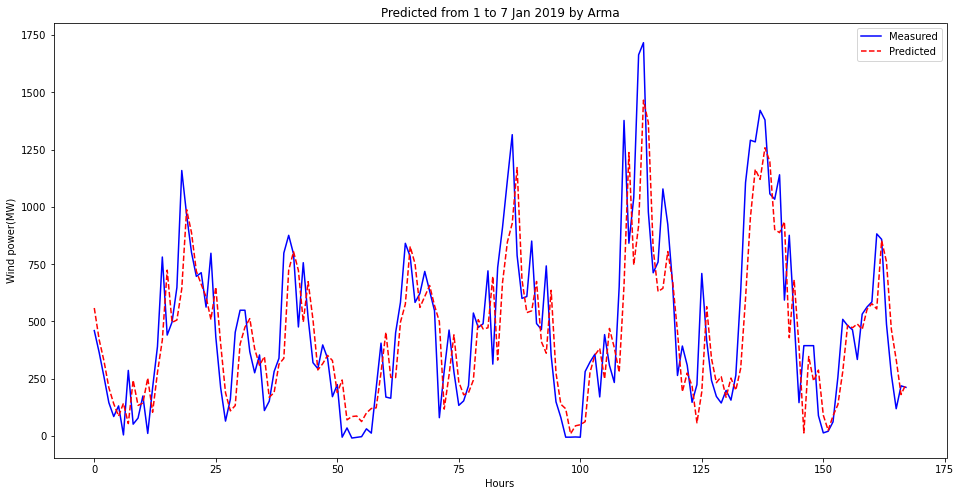

In [61]:
result_display(y_test_arma,y_predict_arma,'Arma')


In [ ]:
np.hstack([model.forecast(6)[0],model.forecast(6)[0],model.forecast(6)[0]])

In [ ]:


model = keras.Sequential()
model.add(keras.Input(shape=(None,1)))
model.add(LSTM(input_shape=(None,1),units=12,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(input_shape=(None,12),units=128,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(input_shape=(None,128),units=256,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(256,return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.add(Activation("linear"))

model.compile(loss=keras.losses.MeanAbsolutePercentageError(),optimizer='adam')

model.fit(x_train,y_train,batch_size=10,epochs=10,verbose=1)

# model = keras.Sequential()
# model.add(keras.Input(shape=(None,1)))
# model.add(
#     layers.SimpleRNN(512,return_sequences = True, activation='relu')
# )
# model.add(layers.SimpleRNN(256,return_sequences = True,activation='relu'))
# model.add(layers.SimpleRNN(256,activation='relu'))
# model.add(layers.Dense(1))
# model.compile(loss=keras.losses.MeanAbsolutePercentageError(),optimizer='adam')
# model.fit(x_train,y_train,epochs=15, verbose=1)

##  Only using wind speed and wind direction to do prediction

In [16]:

def standardize(df):
    return (df-np.min(df))/(np.max(df)-np.min(df))

df['WindDirection'] = standardize(df['WindDirection'])
df['WindSpeed'] = standardize(df['WindSpeed'])



x_train = [[]]
y_train = [0]
y_time =[[]]

hours = 0
for i in range(0,len(df)-6,6):
    hours += 1
    
    x_train.append([])
    
    y_time.append([])
    for j in range(i,i+6):
        x_train[hours].append(df.iloc[j,18])
        x_train[hours].append(df.iloc[j,19])
    y_train.append(df.iloc[i+6,1])
    y_time[hours] = df.iloc[i+6,0]
    


def training_rf(p,x_train,y_train):
    model = RandomForestRegressor(n_estimators= p,max_features='sqrt')
    model.fit(x_train, y_train)
    return model

def training_gb(p1,p2,x_train,y_train):
    model = GradientBoostingRegressor(n_estimators= p1,max_features='sqrt',learning_rate=p2,random_state=167,max_depth=7)
    model.fit(x_train, y_train)
    return model

    
def predict(model,x_test):
    predicted_y = model.predict(x_test)
    return predicted_y


y_test_time = []
def build_rf_model(k=0,p=30):
    y_test = []
    y_predict_rf = []
    
   
    model_rf = training_rf(p,x_train[1+24*k : (365+k)* 24],y_train[1+24*k : (365+k)*24])
    for j in range(1+ 91 * 3*24, 1+ (91 * 3 + 7)*24):
        pre = predict(model_rf,[x_train[j+24*(k+365)]])[0]
        y_predict_rf.append(pre)

        y_test.append(y_train[j+24*(k+365)])
        
    return y_test, y_predict_rf

def build_gb_model(k=0,p1=200,p2=0.15):    
    y_test = []
    y_predict_gb = []
   
    model_gb = training_gb(p1,p2,x_train[1+24*k : (365+k)* 24], y_train[1+24*k : (365+k)*24])
    for j in range(1+ 91 * 3*24, 1+ (91 * 3 + 7)*24):
            y_predict_gb.append(predict(model_gb,[x_train[j+24*(k+365)]])[0])
            y_test.append(y_train[j+24*(k+365)])
    return y_test,y_predict_gb




## Result display for random forest

63.21636616991916
667.7476457682384
4.9356001380709715
13162.438261798727


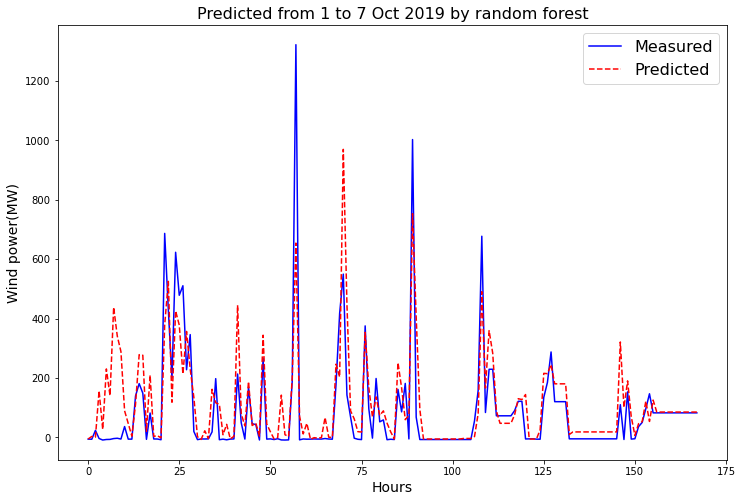

In [17]:
y_test,y_predict_rf = build_rf_model()

result_display(y_test,y_predict_rf,'random forest') 





## Result display for gradient boost

60.931508235733276
805.7473023207316
4.380280184361758
13641.41718993548


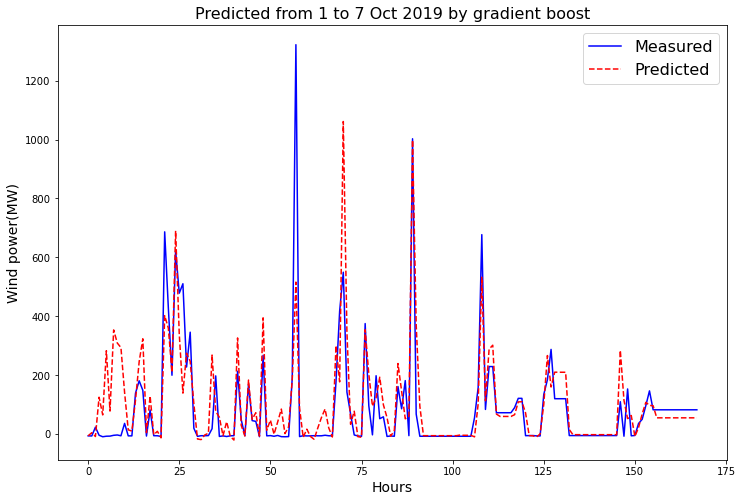

In [18]:
y_test,y_predict = build_gb_model()
result_display(y_test,y_predict,'gradient boost')



In [1]:

def result_display(y_test,y_predict,model_name):
   
    y_test = np.array(y_test)
    y_predict = np.array(y_predict)
    # MAE
    mae = mean_absolute_error(y_test, y_predict)
    # MXE
    mxe = max_error(y_test,y_predict)
    # MAPE
    mape = np.mean(abs((y_test-y_predict)/y_test))
    # MSPE
    mse = mean_squared_error(y_test,y_predict)
    
    

    print(mae)
    print(mxe)
    print(mape)
    print(mse)
    

    plt.figure(figsize=(12,8))
    plt.ylabel('Wind power(MW)',fontsize=14)
    plt.xlabel('Hours',fontsize=14)
    plt.plot(y_test, color = 'blue', label='Measured')
    plt.plot(y_predict,color = 'red',linestyle='--',label='Predicted')
    plt.title('Predicted from 1 to 7 Oct 2019 by ' + model_name, fontsize=16)
    plt.legend(fontsize=16)
    plt.show()

In [557]:
result1= []
for k in range(0,200):
    y_test,y_predict = build_gb_model(k=k)
    mae = mean_absolute_error(y_test, y_predict)
    mse = mean_squared_error(y_test,y_predict)
    #mape = mean_absolute_percentage_error(y_test, y_predict)
    
    result1.append(mae)
var1 = result1
    

In [561]:
result2= []
for k in range(0,200):
    y_test,y_predict = build_rf_model(k=k)
    mae = mean_absolute_error(y_test, y_predict)
    result2.append(mae)
var2 = result2

KeyboardInterrupt: 

In [562]:
data = pd.DataFrame({'Gradientboost': var1, 'RandomForest': var2})

In [563]:
print(data)
print(np.mean(data['Gradientboost']),np.mean(data['RandomForest']))
print(np.std(data['Gradientboost']),np.std(data['RandomForest']))

     Gradientboost  RandomForest
0        83.534820     79.785635
1        78.785199     83.180656
2        80.518960     95.997582
3       108.923070     95.599902
4       120.262130    127.201280
..             ...           ...
195     154.262249    135.890440
196     174.865182    180.766519
197     149.844914    131.411703
198     184.617255    189.827066
199      97.311226     95.443985

[200 rows x 2 columns]
117.78532427479865 113.46791131030244
47.23721312340738 46.83552087999879


In [564]:
import scipy.stats as stats


#stats.wilcoxon(var1,var2,alternative='greater')
#stats.wilcoxon(var2,var1,alternative='greater')
result = autorank(data,alpha=0.05, verbose=False)
print(result)
create_report(result)



RankResult(rankdf=
               meanrank      median        mad    ci_lower    ci_upper  \
RandomForest        1.6  108.246580  24.766431   95.894259  120.074781   
Gradientboost       1.4  112.773742  30.564285  104.202019  124.226417   

              effect_size   magnitude  
RandomForest          0.0  negligible  
Gradientboost   -0.109773  negligible  
pvalue=4.53323091451397e-05
cd=None
omnibus=wilcoxon
posthoc=None
all_normal=False
pvals_shapiro=[3.6725957670569187e-06, 3.5884422686649486e-05]
homoscedastic=True
pval_homogeneity=0.8077791971456478
homogeneity_test=levene
alpha=0.05
alpha_normality=0.025
num_samples=200
posterior_matrix=
None
decision_matrix=
None
rope=None
rope_mode=None
effect_size=akinshin_gamma)
The statistical analysis was conducted for 2 populations with 200 paired samples.
The family-wise significance level of the tests is alpha=0.050.
We rejected the null hypothesis that the population is normal for the populations RandomForest (p=0.000) and Gradientboo

array([[113.04564933, 109.70801277, 108.50269629, 107.08149252,
        107.15053828],
       [107.84100498, 107.42732375, 107.18530894, 106.71673252,
        106.75388895],
       [106.99014591, 106.73863351, 106.62090486, 106.35093179,
        106.3805596 ]])

RankResult(rankdf=
       meanrank    median       mad  ci_lower  ci_upper effect_size  \
pop_0      2.48  0.129756  0.129756       0.0  0.312709         0.0   
pop_1      1.96  0.313824  0.166828  0.156248  0.543758   -0.830746   
pop_2      1.56  0.505057  0.225006  0.259317  0.676057   -1.378267   

        magnitude  
pop_0  negligible  
pop_1       large  
pop_2       large  
pvalue=2.14996318233048e-05
cd=0.4687407979349457
omnibus=friedman
posthoc=nemenyi
all_normal=False
pvals_shapiro=[1.646607051952742e-05, 0.0605173334479332, 0.13884511590003967]
homoscedastic=True
pval_homogeneity=0.06342174035709218
homogeneity_test=levene
alpha=0.05
alpha_normality=0.016666666666666666
num_samples=50
posterior_matrix=
None
decision_matrix=
None
rope=None
rope_mode=None
effect_size=akinshin_gamma)
The statistical analysis was conducted for 3 populations with 50 paired samples.
The family-wise significance level of the tests is alpha=0.050.
We rejected the null hypothesis that the population

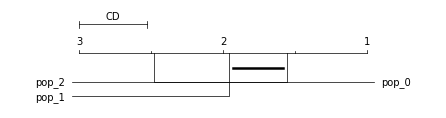

In [228]:
np.random.seed(42)
pd.set_option('display.max_columns', 7)
std = 0.3
means = [0.2, 0.3, 0.5]
sample_size = 50
data = pd.DataFrame()
for i, mean in enumerate(means):
    data['pop_%i' % i] = np.random.normal(mean, std, sample_size).clip(0, 1)
    
result = autorank(data, alpha=0.05, verbose=False)
print(result)
create_report(result)
plot_stats(result)
plt.show()